In [1]:
# import modules
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt

import seaborn as sns 

In [2]:
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve

from sklearn.metrics import roc_auc_score

In [3]:
# read data 
df=pd.read_csv('ppg_corrosion.csv')

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 79 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   X01        2000 non-null   float64
 1   X02        2000 non-null   float64
 2   X03        2000 non-null   float64
 3   X04        2000 non-null   float64
 4   X05        2000 non-null   float64
 5   X06        2000 non-null   float64
 6   X07        2000 non-null   float64
 7   X08        2000 non-null   float64
 8   X09        2000 non-null   float64
 9   X10        2000 non-null   float64
 10  X11        2000 non-null   float64
 11  X12        2000 non-null   float64
 12  X13        2000 non-null   float64
 13  X14        2000 non-null   float64
 14  X15        2000 non-null   float64
 15  X16        2000 non-null   int64  
 16  X17        2000 non-null   int64  
 17  X18        2000 non-null   int64  
 18  X19        2000 non-null   float64
 19  X20        2000 non-null   float64
 20  X21     

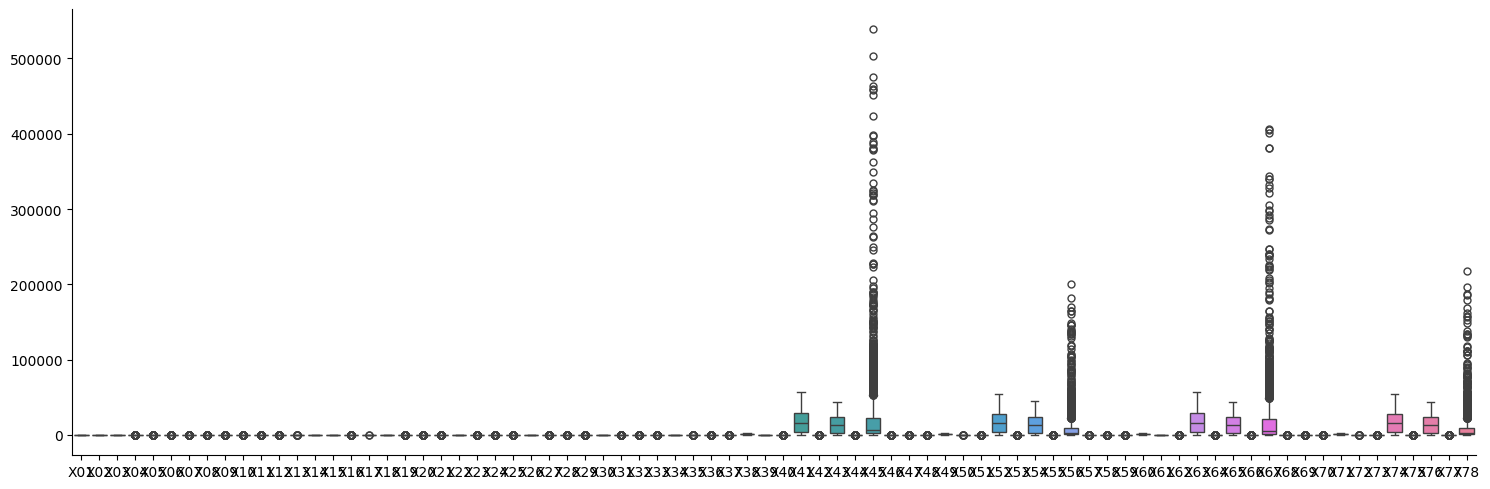

In [5]:
sns.catplot(data =df, kind='box', aspect=3)

plt.show()

Big scale difference, need standardize the data

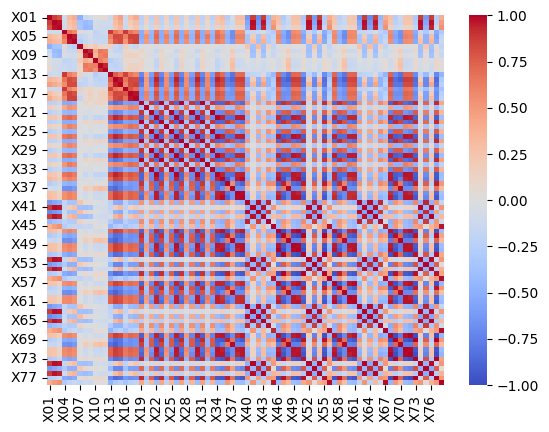

In [6]:
fig, ax = plt.subplots()

sns.heatmap(data = df.corr(numeric_only=True),
            vmin=-1, vmax=1, center=0,
            cmap='coolwarm', 
            ax=ax)

plt.show()

many features have high correlations with other features. we can use pca to reduce the correlation

In [7]:
input_features = df.select_dtypes('number').copy().columns

In [8]:
lf = df.copy().reset_index().rename(columns={'index': 'rowid'}).\
melt(id_vars=['rowid', 'corrosion'], value_vars=input_features, ignore_index=True)

In [9]:
lf.head()

rowid corrosion variable     value
0      0       yes      X01   52.4988
1      1        no      X01  163.6560
2      2        no      X01  218.9088
3      3       yes      X01   45.7112
4      4        no      X01  244.6048

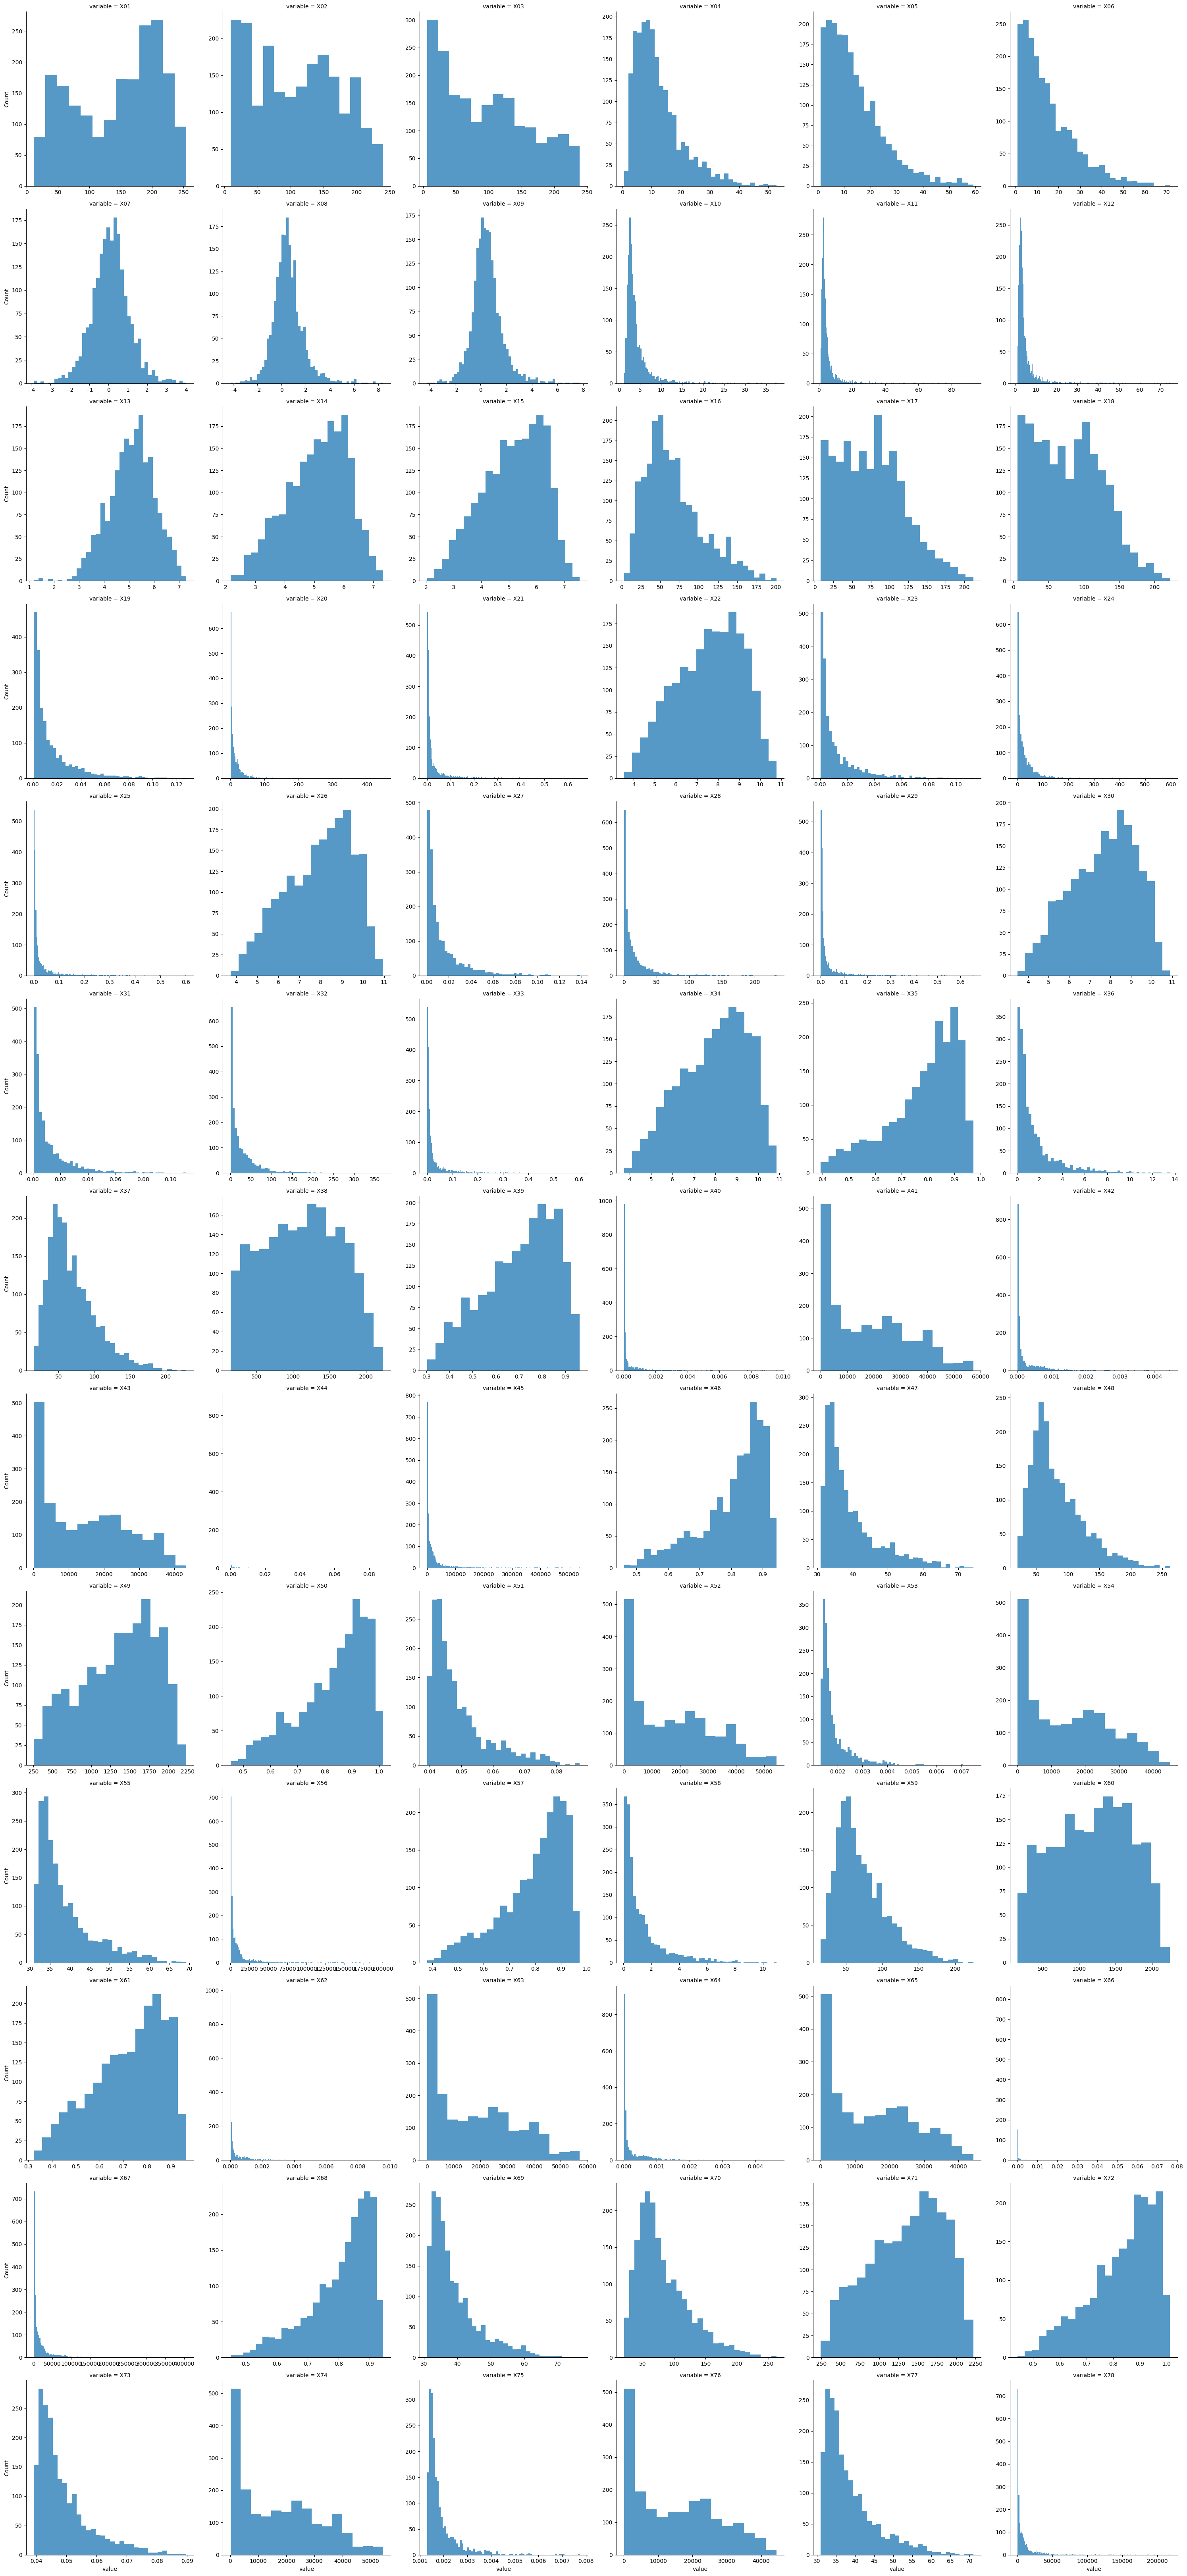

In [10]:
sns.displot(data =lf, x='value', kind='hist', col='variable', col_wrap=6,
            facet_kws={"sharex":False, "sharey":False},
            common_bins=False)
plt.show()

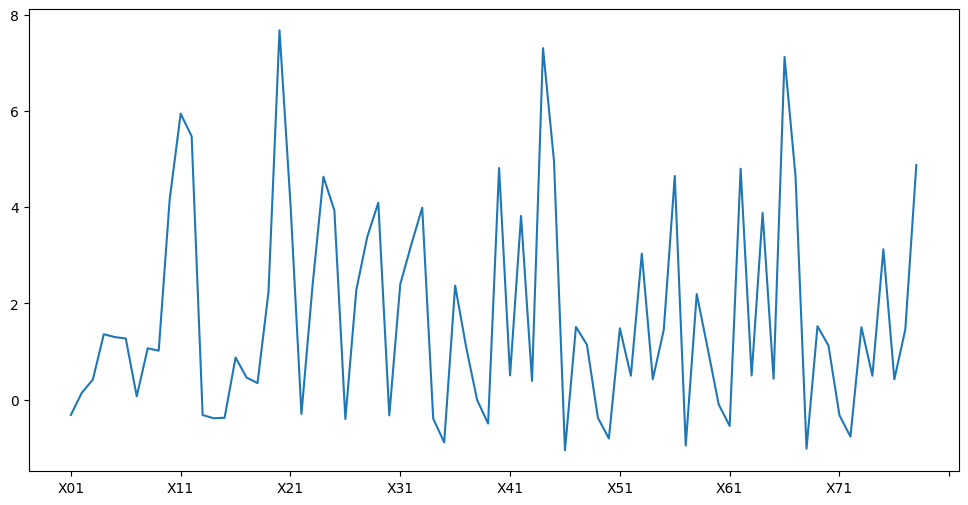

In [11]:
#calculate skew and plot the skew.
fig, ax = plt.subplots(figsize=(12,6))

df.select_dtypes('number').skew().plot(ax=ax)

plt.show()

In [12]:
small_skew_inputs = input_features[ df.select_dtypes('number').skew().between(-0.35, 0.35, inclusive='both') ]

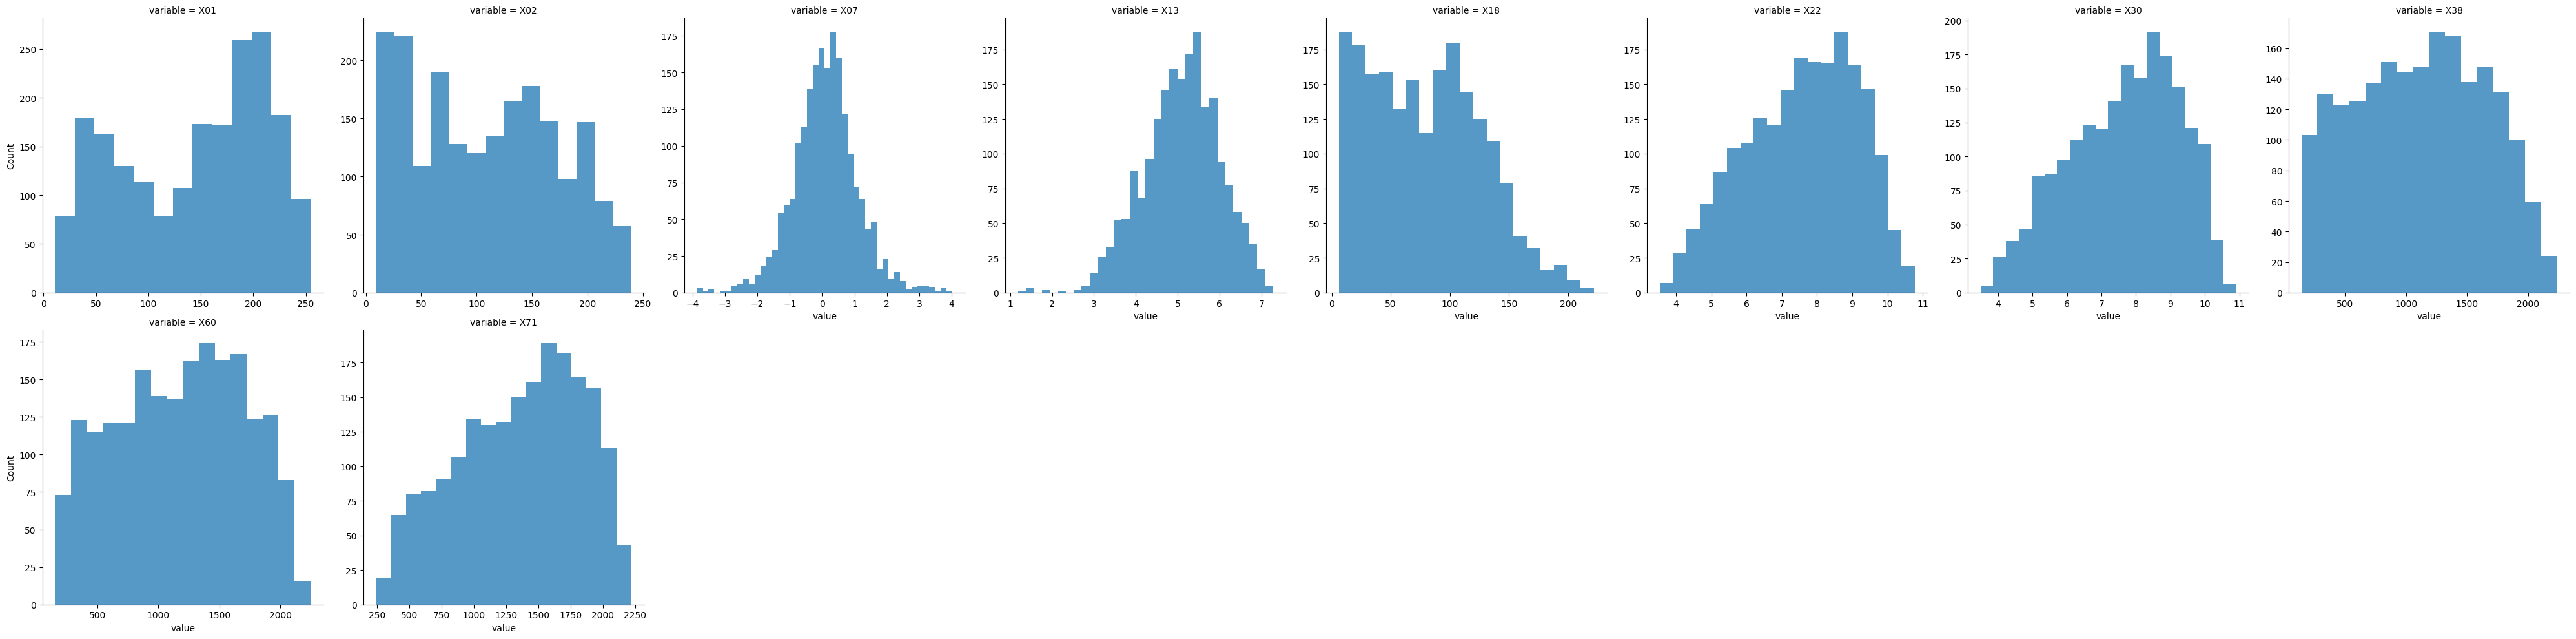

In [13]:
sns.displot(data = lf.loc[ lf.variable.isin( small_skew_inputs ), : ], 
            x='value', col='variable', kind='hist', col_wrap=8,
            facet_kws={'sharex': False, 'sharey': False},
            common_bins=False)

plt.show()

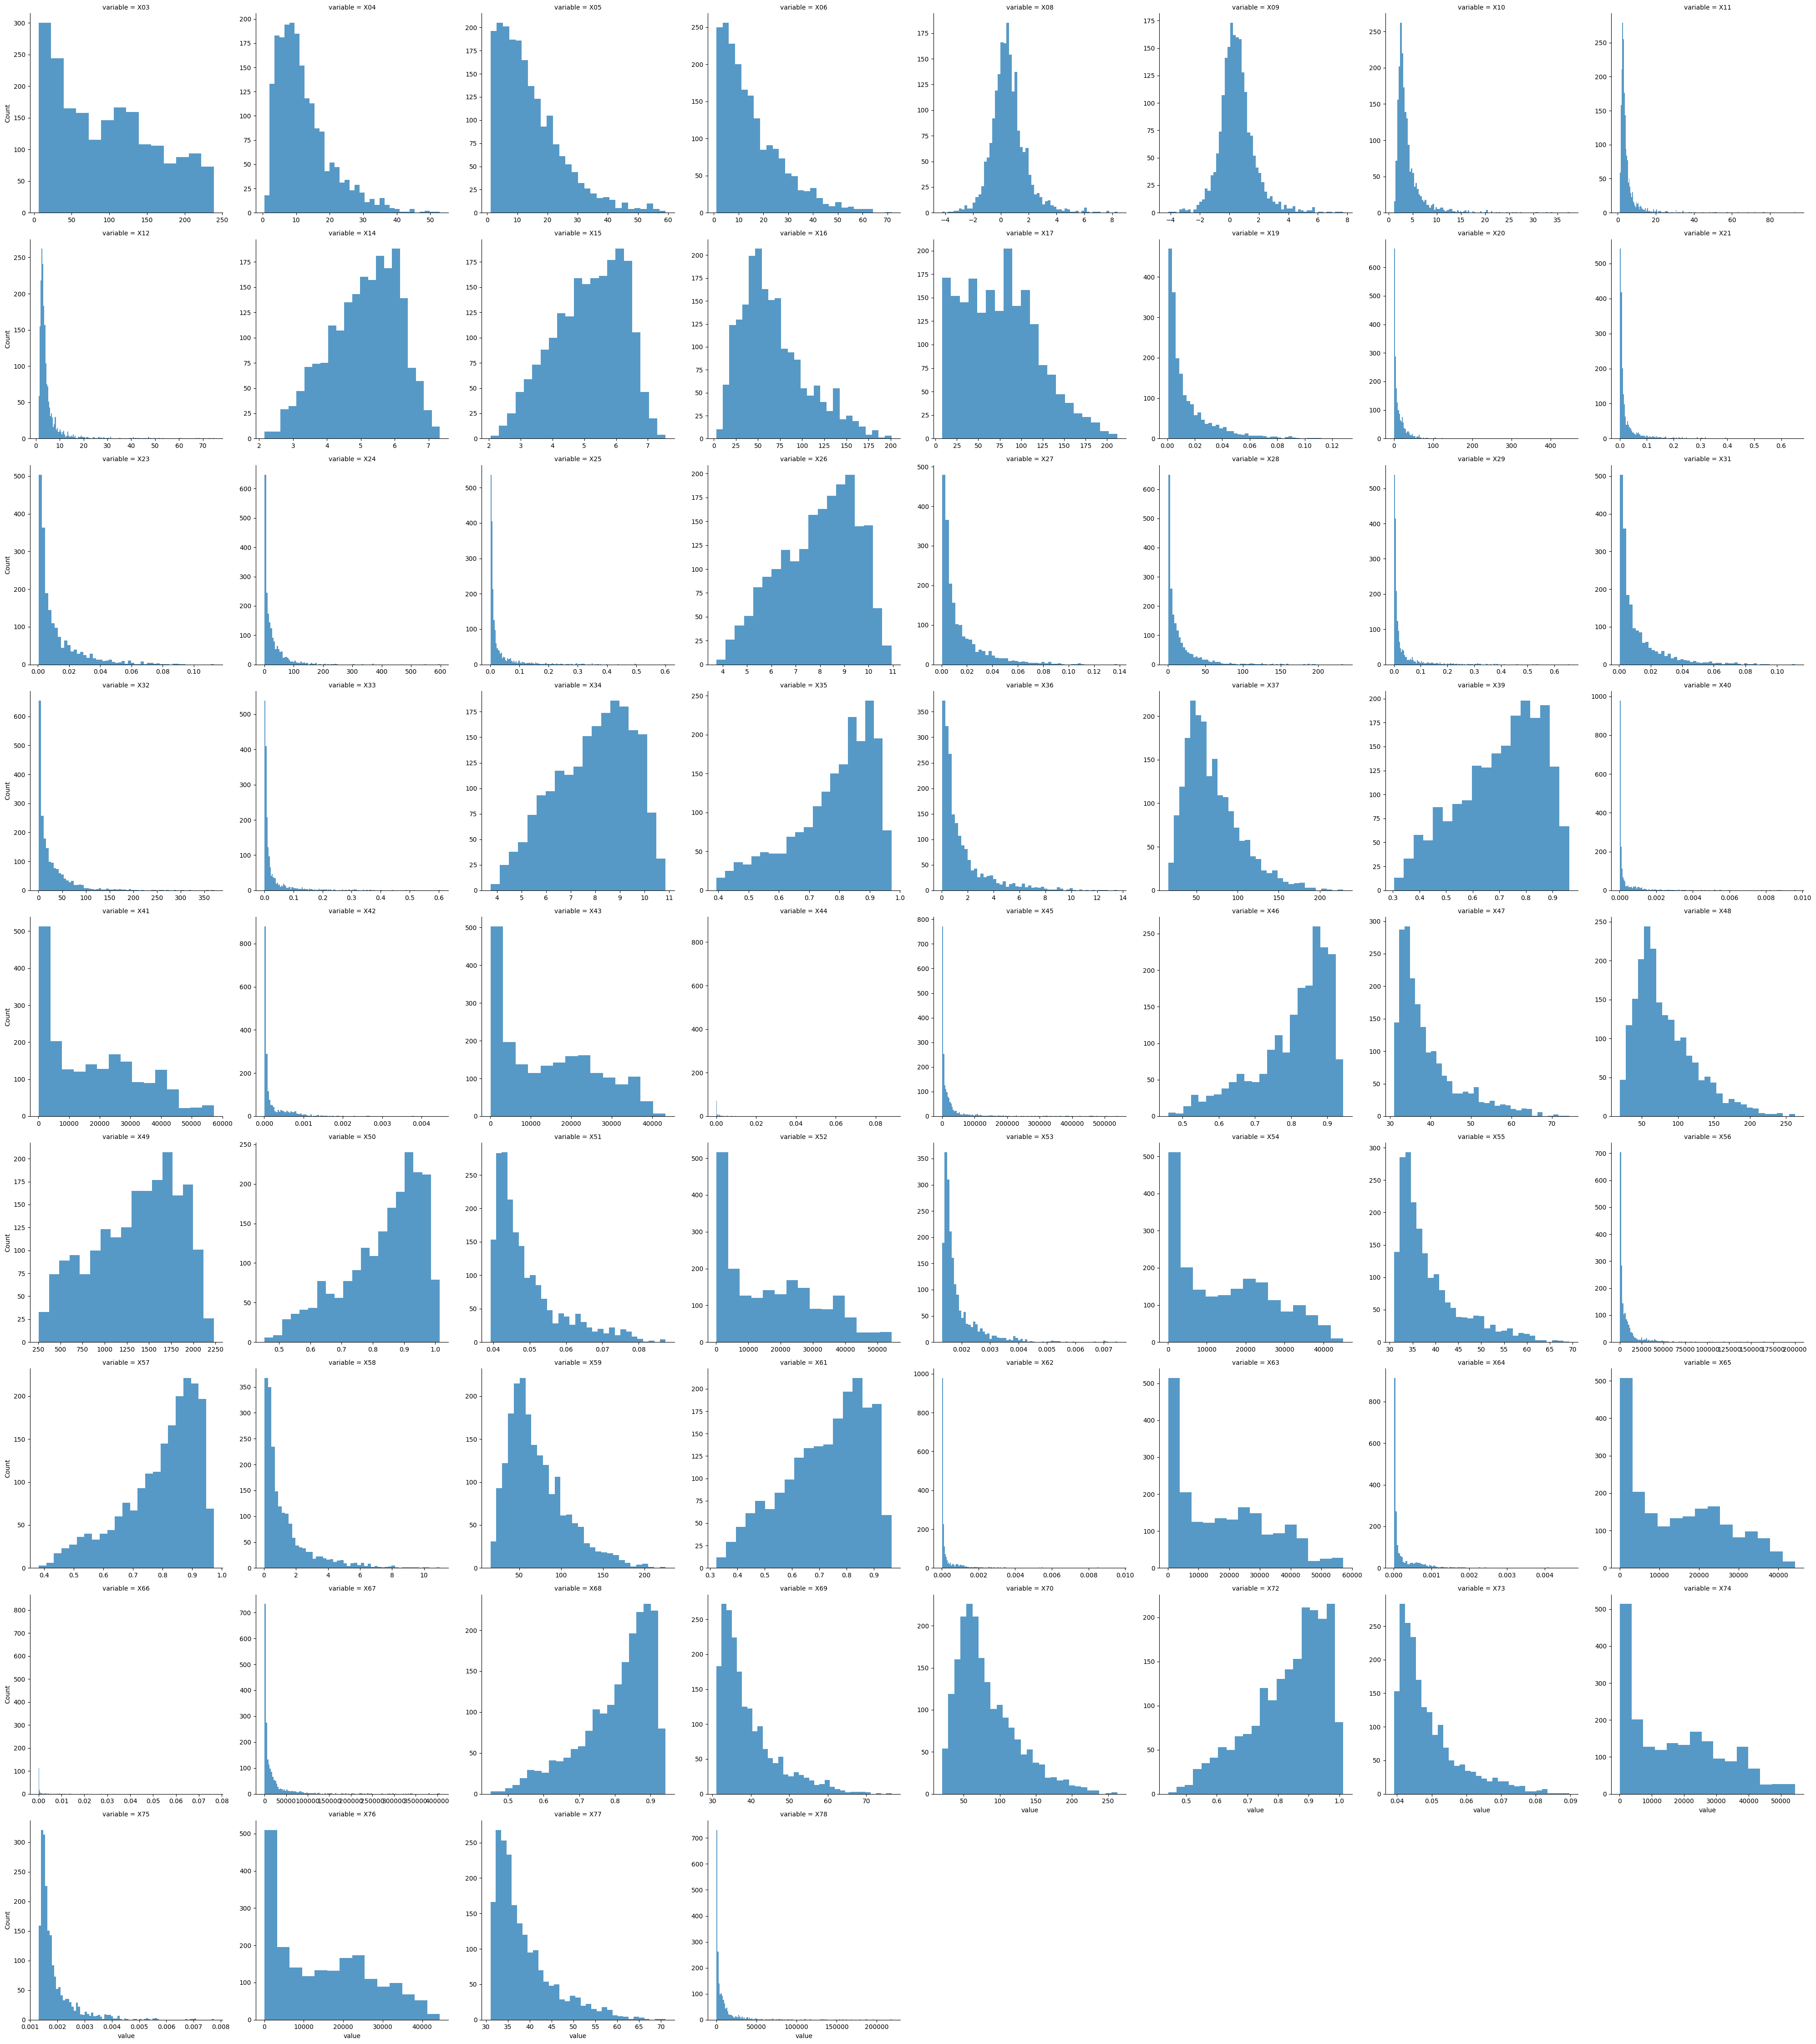

In [14]:
sns.displot(data = lf.loc[ ~lf.variable.isin( small_skew_inputs ), : ], 
            x='value', col='variable', kind='hist', col_wrap=8,
            facet_kws={'sharex': False, 'sharey': False},
            common_bins=False)

plt.show()

In [15]:
#Check 0 values
lf.loc[ (lf.value == 0), :].groupby(['variable']).size()

Series([], dtype: int64)

In [16]:
# check negative values
lf.loc[ (~lf.variable.isin(small_skew_inputs)) & (lf.value < 0), :].groupby(['variable']).size()

variable
X08    627
X09    630
dtype: int64

In [17]:
lf_skew = lf.loc[ ~lf.variable.isin(small_skew_inputs), :].copy()

lf_skew = lf_skew.loc[ ~lf_skew.variable.isin(['X08', 'X09']), :].copy()

In [18]:
lf_skew['log_value'] = np.log( lf_skew.value )

In [19]:
lf_skew

rowid corrosion variable        value  log_value
4000        0       yes      X03    15.724800   2.755239
4001        1        no      X03   164.040800   5.100115
4002        2        no      X03   212.413200   5.358533
4003        3       yes      X03    26.906000   3.292349
4004        4        no      X03   129.517200   4.863814
...       ...       ...      ...          ...        ...
155995   1995       yes      X78  3839.905004   8.253203
155996   1996       yes      X78  1282.624212   7.156663
155997   1997       yes      X78  3181.100739   8.064983
155998   1998       yes      X78  2061.489655   7.631184
155999   1999       yes      X78  1569.125784   7.358274

[132000 rows x 5 columns]

In [20]:
lf_1=lf.loc[ lf.variable.isin(small_skew_inputs), :].copy()

In [21]:
lf_1['log_value'] =lf.loc[ lf.variable.isin(small_skew_inputs), :].copy().value

In [22]:
lf_2=lf.loc[ lf.variable.isin(['X08', 'X09']), :].copy()

In [23]:
lf_2['log_value'] =lf_2.value

In [24]:
lf_2

rowid corrosion variable     value  log_value
14000      0       yes      X08  0.165502   0.165502
14001      1        no      X08 -2.654124  -2.654124
14002      2        no      X08 -0.718916  -0.718916
14003      3       yes      X08  0.434857   0.434857
14004      4        no      X08  1.971901   1.971901
...      ...       ...      ...       ...        ...
17995   1995       yes      X09 -0.495143  -0.495143
17996   1996       yes      X09  0.313693   0.313693
17997   1997       yes      X09 -0.216146  -0.216146
17998   1998       yes      X09  2.202250   2.202250
17999   1999       yes      X09 -0.429107  -0.429107

[4000 rows x 5 columns]

In [25]:
lf_skew.shape

(132000, 5)

In [26]:
lf_2.shape

(4000, 5)

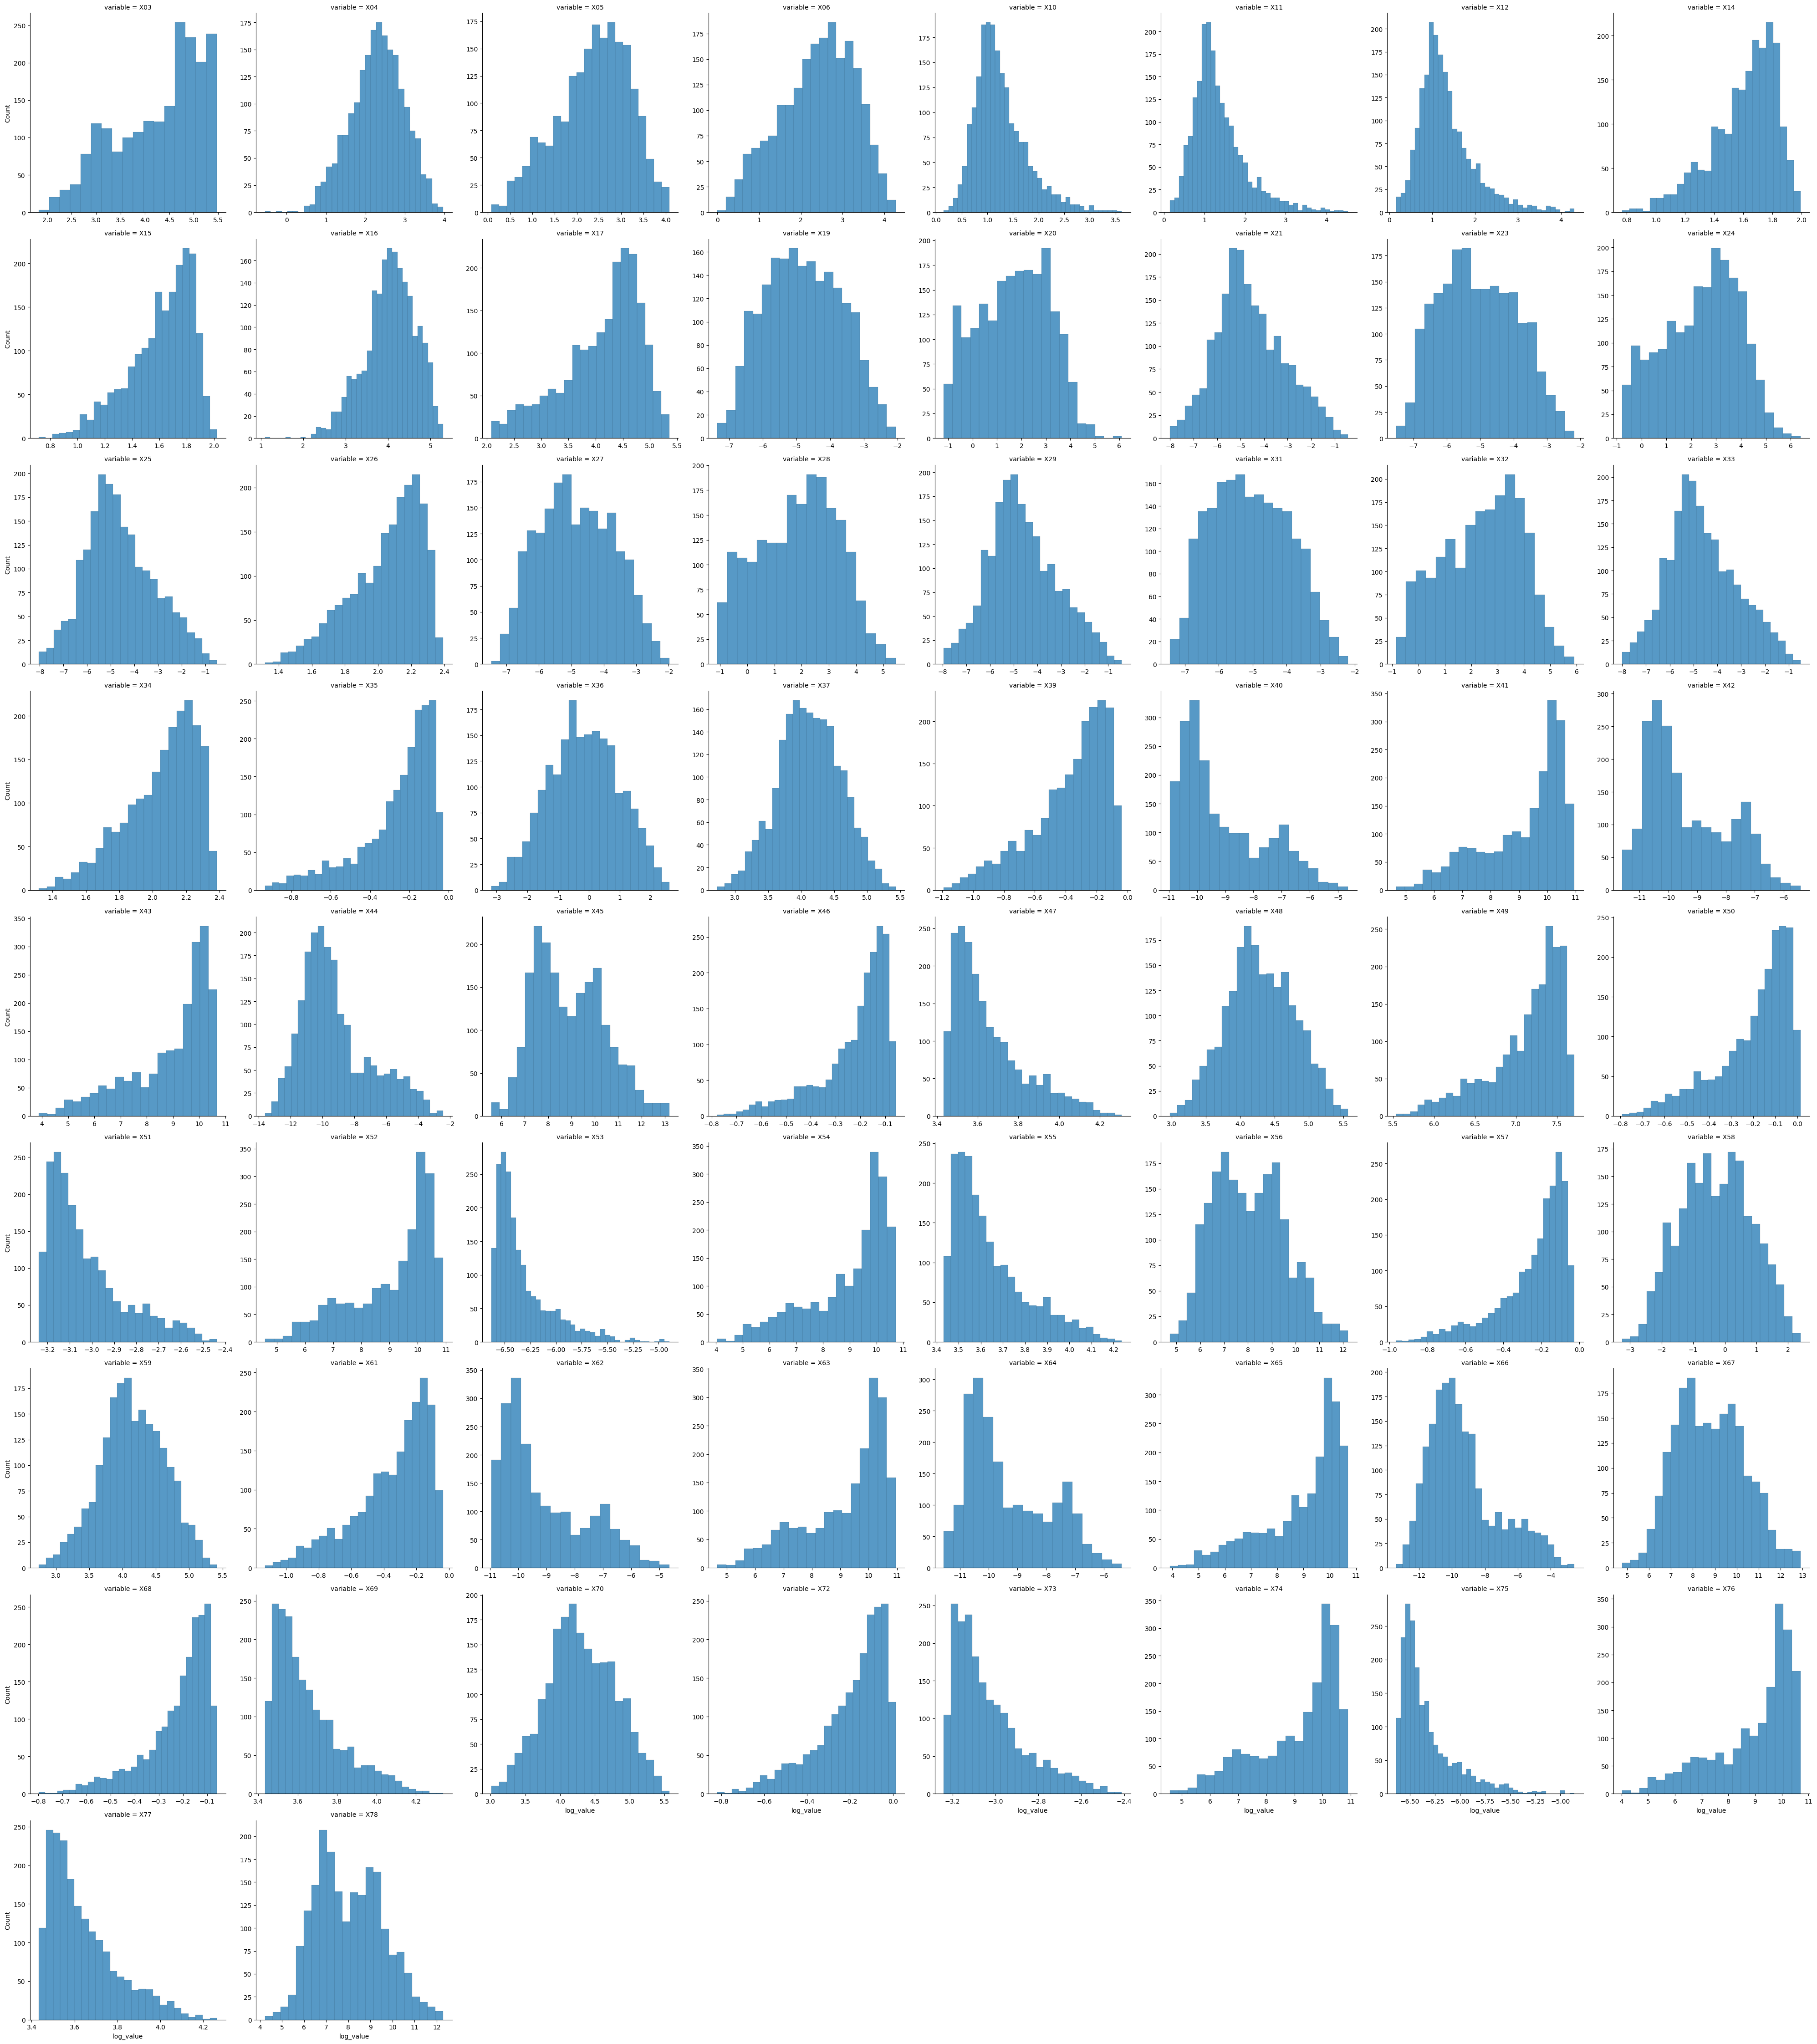

In [27]:
sns.displot(data = lf_skew, 
            x='log_value', col='variable', kind='hist', col_wrap=8,
            facet_kws={'sharex': False, 'sharey': False},
            common_bins=False)

plt.show()

In [28]:
df_combine=pd.concat([lf_1,lf_2,lf_skew],ignore_index=True)

In [29]:
df_combine

rowid corrosion variable        value   log_value
0           0       yes      X01    52.498800   52.498800
1           1        no      X01   163.656000  163.656000
2           2        no      X01   218.908800  218.908800
3           3       yes      X01    45.711200   45.711200
4           4        no      X01   244.604800  244.604800
...       ...       ...      ...          ...         ...
155995   1995       yes      X78  3839.905004    8.253203
155996   1996       yes      X78  1282.624212    7.156663
155997   1997       yes      X78  3181.100739    8.064983
155998   1998       yes      X78  2061.489655    7.631184
155999   1999       yes      X78  1569.125784    7.358274

[156000 rows x 5 columns]

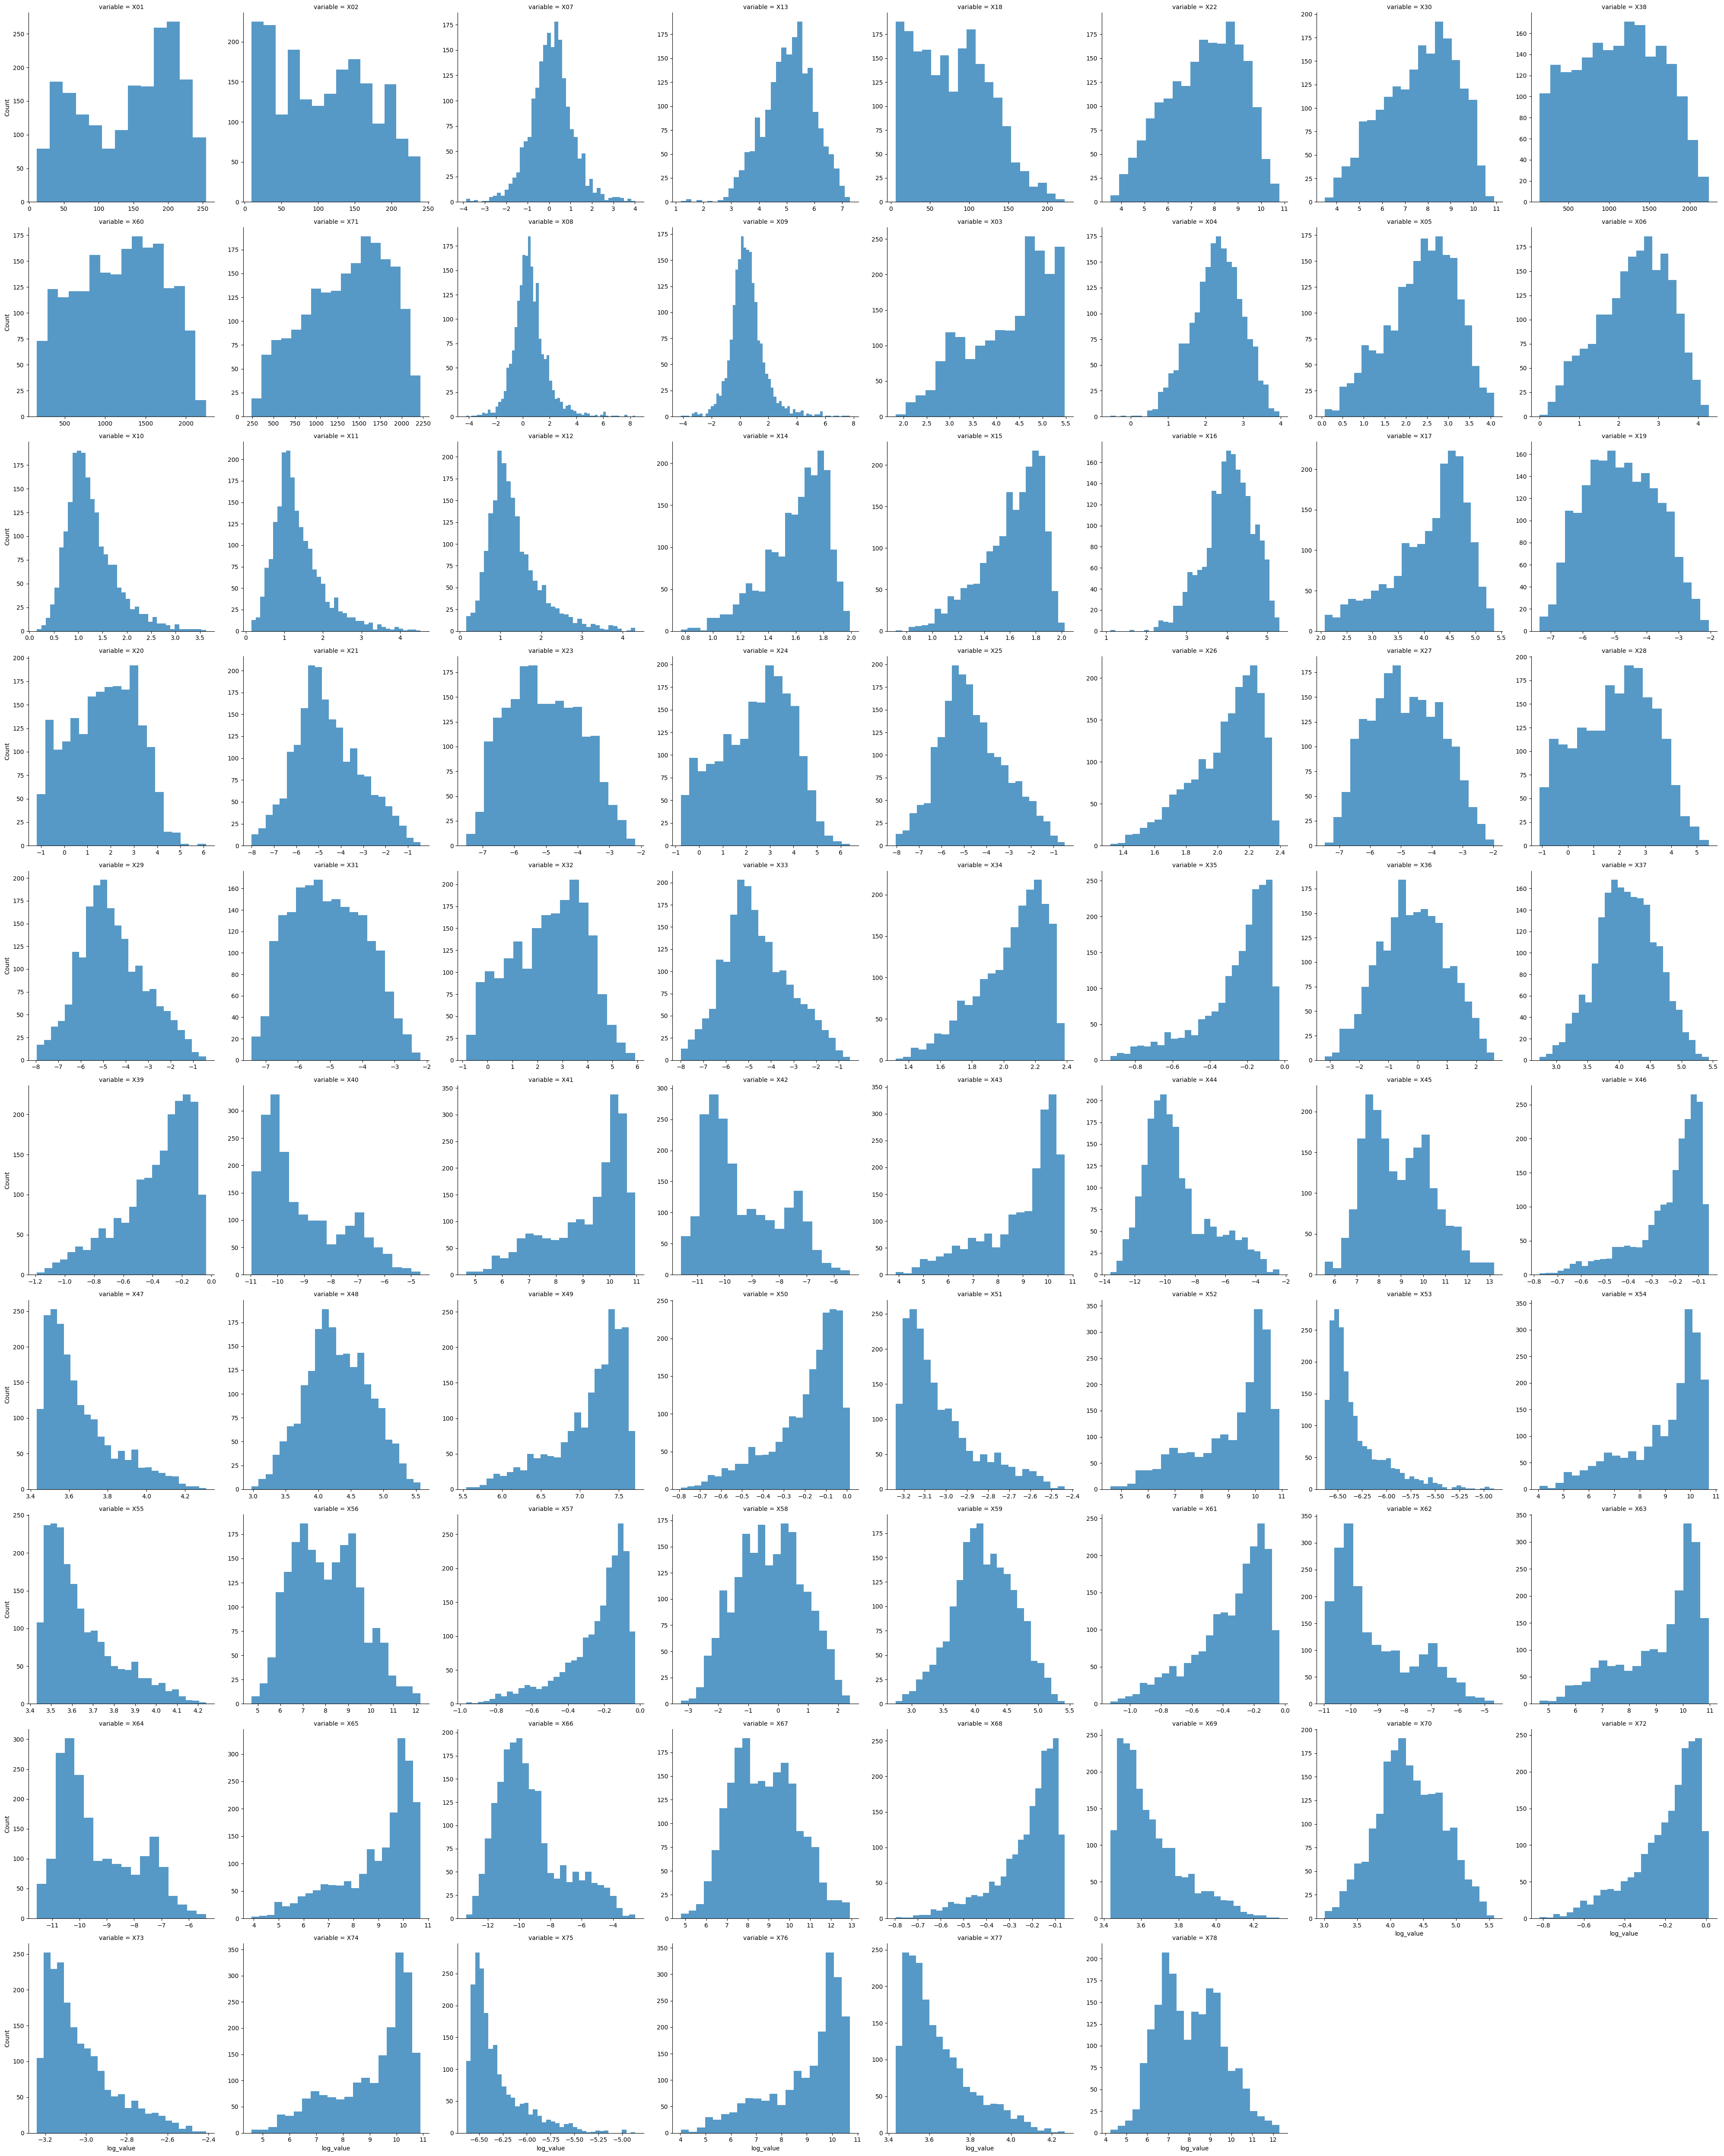

In [30]:
sns.displot(data = df_combine, 
            x='log_value', col='variable', kind='hist', col_wrap=8,
            facet_kws={'sharex': False, 'sharey': False},
            common_bins=False)

plt.show()

In [31]:
df_wide=df_combine.pivot_table(index=['rowid','corrosion'],columns='variable', values='log_value').reset_index()

In [32]:
df_wide.drop('rowid', axis =1, inplace=True)

In [33]:
df_wide.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 79 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   corrosion  2000 non-null   object 
 1   X01        2000 non-null   float64
 2   X02        2000 non-null   float64
 3   X03        2000 non-null   float64
 4   X04        2000 non-null   float64
 5   X05        2000 non-null   float64
 6   X06        2000 non-null   float64
 7   X07        2000 non-null   float64
 8   X08        2000 non-null   float64
 9   X09        2000 non-null   float64
 10  X10        2000 non-null   float64
 11  X11        2000 non-null   float64
 12  X12        2000 non-null   float64
 13  X13        2000 non-null   float64
 14  X14        2000 non-null   float64
 15  X15        2000 non-null   float64
 16  X16        2000 non-null   float64
 17  X17        2000 non-null   float64
 18  X18        2000 non-null   float64
 19  X19        2000 non-null   float64
 20  X20     

In [34]:
from sklearn.preprocessing import StandardScaler

In [35]:
transformed_features =df_wide.select_dtypes('number').copy()

In [36]:
transformed_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 78 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   X01     2000 non-null   float64
 1   X02     2000 non-null   float64
 2   X03     2000 non-null   float64
 3   X04     2000 non-null   float64
 4   X05     2000 non-null   float64
 5   X06     2000 non-null   float64
 6   X07     2000 non-null   float64
 7   X08     2000 non-null   float64
 8   X09     2000 non-null   float64
 9   X10     2000 non-null   float64
 10  X11     2000 non-null   float64
 11  X12     2000 non-null   float64
 12  X13     2000 non-null   float64
 13  X14     2000 non-null   float64
 14  X15     2000 non-null   float64
 15  X16     2000 non-null   float64
 16  X17     2000 non-null   float64
 17  X18     2000 non-null   float64
 18  X19     2000 non-null   float64
 19  X20     2000 non-null   float64
 20  X21     2000 non-null   float64
 21  X22     2000 non-null   float64
 22  

In [37]:
Xfeature_trans=StandardScaler().fit_transform(transformed_features)

In [38]:
Xfeature_trans.shape

(2000, 78)

In [39]:
type(Xfeature_trans)

numpy.ndarray

In [40]:
from sklearn.cluster import KMeans

In [41]:
# find the best number of clusters
tots_within=[]
K=range(1,21)
for k in K:
    km = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500).fit(Xfeature_trans)
    tots_within.append(km.inertia_)

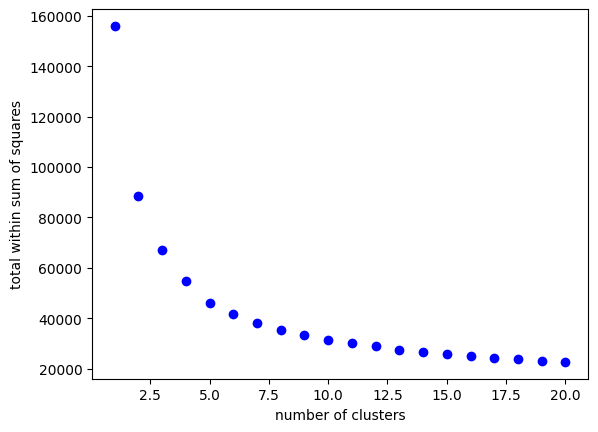

In [42]:
# Visualize the KNEE BEND plot as a line chart
fig, ax =plt.subplots()
ax.plot(K, tots_within, 'bo')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')

plt.show()

From the knee bend plot, we can see, two cluster or three cluster is the best 

In [43]:
# calculate kmeans
cluster2 =KMeans(n_clusters=2, random_state =121, n_init=25, max_iter=500).fit_predict(Xfeature_trans)

In [44]:
cluster2

array([0, 1, 1, ..., 1, 1, 1], dtype=int32)

In [45]:
df_wide_copy=df_wide.copy()

In [46]:
df_wide_copy['k2'] =pd.Series(cluster2, index=df_wide_copy.index).astype('category')

In [47]:
df_wide_copy

variable corrosion       X01       X02       X03       X04       X05  \
0              yes   52.4988   22.4352  2.755239  1.840570  0.756486   
1               no  163.6560  161.7176  5.100115  2.092903  2.566972   
2               no  218.9088  217.9228  5.358533  1.771726  1.968331   
3              yes   45.7112   29.8620  3.292349  1.895589  1.123735   
4               no  244.6048  141.9512  4.863814  1.614227  2.803576   
...            ...       ...       ...       ...       ...       ...   
1995           yes  164.0856  137.2884  4.730890  3.600453  4.005934   
1996           yes   42.5652   24.2252  3.054963  1.764850  0.994272   
1997           yes   80.9216   71.1844  4.209089  3.250144  3.640220   
1998           yes  136.0328   62.9732  3.516500  2.099452  1.845654   
1999           yes  126.4380  119.4280  4.846229  2.587131  2.603975   

variable       X06       X07       X08       X09  ...       X70          X71  \
0         0.334290  0.169325  0.165502 -0.435505  ...  4.740362   395.783685   
1         2.720729  2.292762 -2.654124 -2.700556  ...  4.711942  1116.853313   
2         1.997469 -0.551242 -0.718916 -0.860859  ...  4.617269  1611.247241   
3         0.805235  0.380476  0.434857  0.033068  ...  4.798896   652.679503   
4         2.967406 -1.712171  1.971901  1.974853  ...  4.222211  1072.486039   
...            ...       ...       ...       ...  ...       ...          ...   
1995      3.999846 -0.593199 -0.636593 -0.495143  ...  3.424862  1812.093299   
1996      0.835720  0.335472  0.537995  0.313693  ...  4.848744   611.538462   
1997      3.725347 -0.515049 -0.302666 -0.216146  ...  3.812254  1452.745841   
1998      1.587322  1.262157  1.915884  2.202250  ...  4.742290  1460.018851   
1999      2.513691 -0.764488 -1.018323 -0.429107  ...  4.251160  1871.270790   

variable       X72       X73        X74       X75        X76       X77  \
0        -0.599293 -2.616624   6.789764 -5.839273   6.245589  4.045493   
1        -0.234710 -2.993495  10.125225 -6.392771   9.918099  3.680869   
2        -0.098716 -3.129751  10.720661 -6.534148  10.617556  3.544874   
3        -0.440057 -2.776410   7.026711 -5.969960   6.680490  3.886244   
4        -0.256700 -2.971605  10.256739 -6.373680  10.062221  3.702859   
...            ...       ...        ...       ...        ...       ...   
1995     -0.058477 -3.168502   9.967800 -6.532365   9.883072  3.504635   
1996     -0.455076 -2.757638   6.736514 -5.901823   6.372558  3.901272   
1997     -0.144332 -3.075059   8.717672 -6.274965   8.571768  3.590495   
1998     -0.139262 -3.086561   8.770773 -6.426510   8.651684  3.585421   
1999     -0.043743 -3.183598   9.584560 -6.557372   9.521111  3.489901   

variable       X78  k2  
0         7.701626   0  
1         9.727886   1  
2         9.226167   1  
3         7.584826   0  
4         9.905133   1  
...            ...  ..  
1995      8.253203   1  
1996      7.156663   0  
1997      8.064983   1  
1998      7.631184   1  
1999      7.358274   1  

[2000 rows x 80 columns]

In [48]:
df_wide_copy.k2.value_counts()

1    1327
0     673
Name: k2, dtype: int64

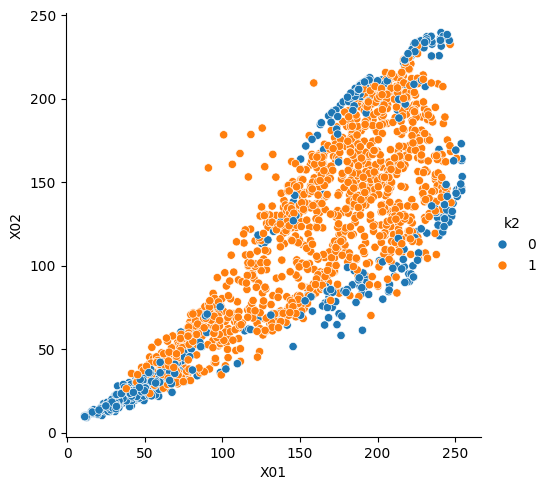

In [49]:
sns.relplot(data =df_wide_copy, x='X01',y='X02', hue='k2')
plt.show()

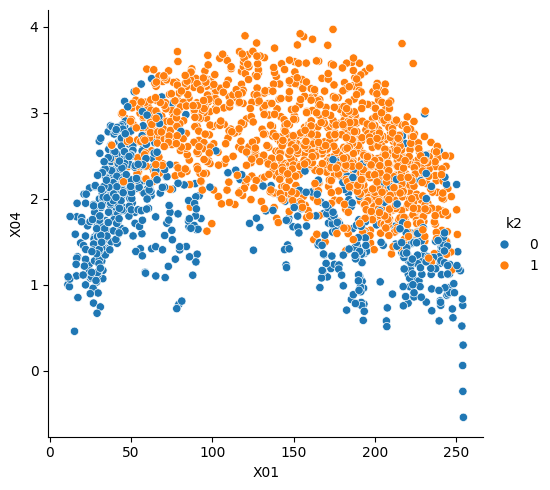

In [50]:
sns.relplot(data =df_wide_copy, x='X01',y='X04', hue='k2')
plt.show()

Executing PCA

In [51]:
from sklearn.decomposition import PCA

In [52]:
pca=PCA(n_components=2)
pca_cor =pca.fit_transform(Xfeature_trans)
print("The variance explained by the two first principal components is: ", sum(pca.explained_variance_ratio_))

The variance explained by the two first principal components is:  0.833778210978186


In [53]:
# Convert the numpy array pca_cor into a DataFrame 
pca_cor_df=pd.DataFrame(pca_cor,columns=['pc01','pc02'])

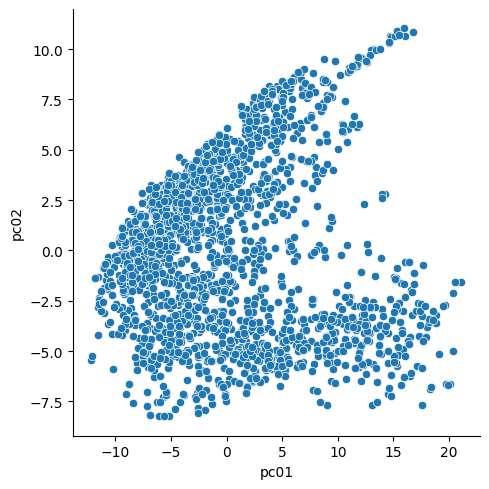

In [54]:
sns.relplot(data =pca_cor_df,x='pc01', y='pc02')
plt.show()

In [55]:
pca_cor_df['corrosion'] =df.corrosion

In [56]:
pca_cor_df

pc01      pc02 corrosion
0     15.674456 -1.596585       yes
1      1.464405  4.402745        no
2     -2.379065  4.820816        no
3     11.050159 -2.327017       yes
4     -0.040738  4.560104        no
...         ...       ...       ...
1995  -8.715430 -0.846569       yes
1996  12.265139 -2.827677       yes
1997  -2.520887 -2.816976       yes
1998   1.309858 -0.917317       yes
1999  -5.129967 -0.386370       yes

[2000 rows x 3 columns]

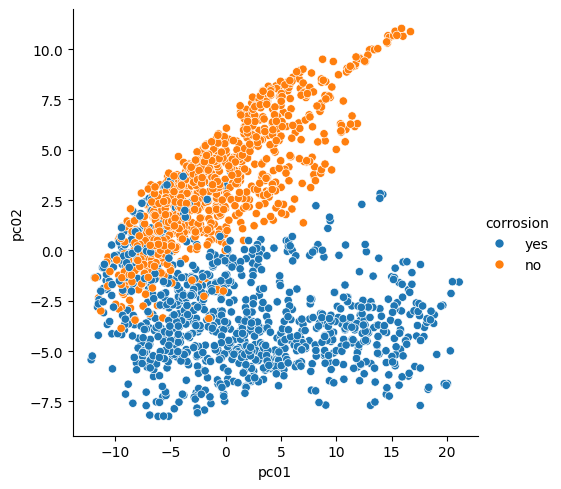

In [57]:
sns.relplot(data=pca_cor_df,x='pc01',y='pc02',hue='corrosion')
plt.show()

In [58]:
pca_cor_df['k2'] =pd.Series(cluster2, index=pca_cor_df.index).astype('category')

In [59]:
pca_cor_df

pc01      pc02 corrosion k2
0     15.674456 -1.596585       yes  0
1      1.464405  4.402745        no  1
2     -2.379065  4.820816        no  1
3     11.050159 -2.327017       yes  0
4     -0.040738  4.560104        no  1
...         ...       ...       ... ..
1995  -8.715430 -0.846569       yes  1
1996  12.265139 -2.827677       yes  0
1997  -2.520887 -2.816976       yes  1
1998   1.309858 -0.917317       yes  1
1999  -5.129967 -0.386370       yes  1

[2000 rows x 4 columns]

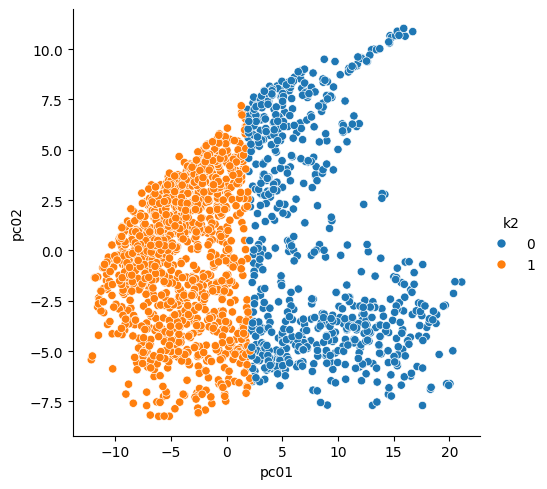

In [60]:
sns.relplot(data=pca_cor_df,x='pc01',y='pc02',hue='k2')
plt.show()

# execute PCA without choosing pc numbers

In [61]:

df_pca=PCA().fit_transform(Xfeature_trans)

In [62]:
df_pca.shape

(2000, 78)

In [63]:
df_pca_pc=pd.DataFrame(df_pca,
                       columns=['pc%02d' % d for d in range(1,df_pca.shape[1]+1)])

In [64]:
df_pca_pc.shape

(2000, 78)

In [65]:
df_pca_pc.columns

Index(['pc01', 'pc02', 'pc03', 'pc04', 'pc05', 'pc06', 'pc07', 'pc08', 'pc09',
       'pc10', 'pc11', 'pc12', 'pc13', 'pc14', 'pc15', 'pc16', 'pc17', 'pc18',
       'pc19', 'pc20', 'pc21', 'pc22', 'pc23', 'pc24', 'pc25', 'pc26', 'pc27',
       'pc28', 'pc29', 'pc30', 'pc31', 'pc32', 'pc33', 'pc34', 'pc35', 'pc36',
       'pc37', 'pc38', 'pc39', 'pc40', 'pc41', 'pc42', 'pc43', 'pc44', 'pc45',
       'pc46', 'pc47', 'pc48', 'pc49', 'pc50', 'pc51', 'pc52', 'pc53', 'pc54',
       'pc55', 'pc56', 'pc57', 'pc58', 'pc59', 'pc60', 'pc61', 'pc62', 'pc63',
       'pc64', 'pc65', 'pc66', 'pc67', 'pc68', 'pc69', 'pc70', 'pc71', 'pc72',
       'pc73', 'pc74', 'pc75', 'pc76', 'pc77', 'pc78'],
      dtype='object')

### Visualize the Principle Components

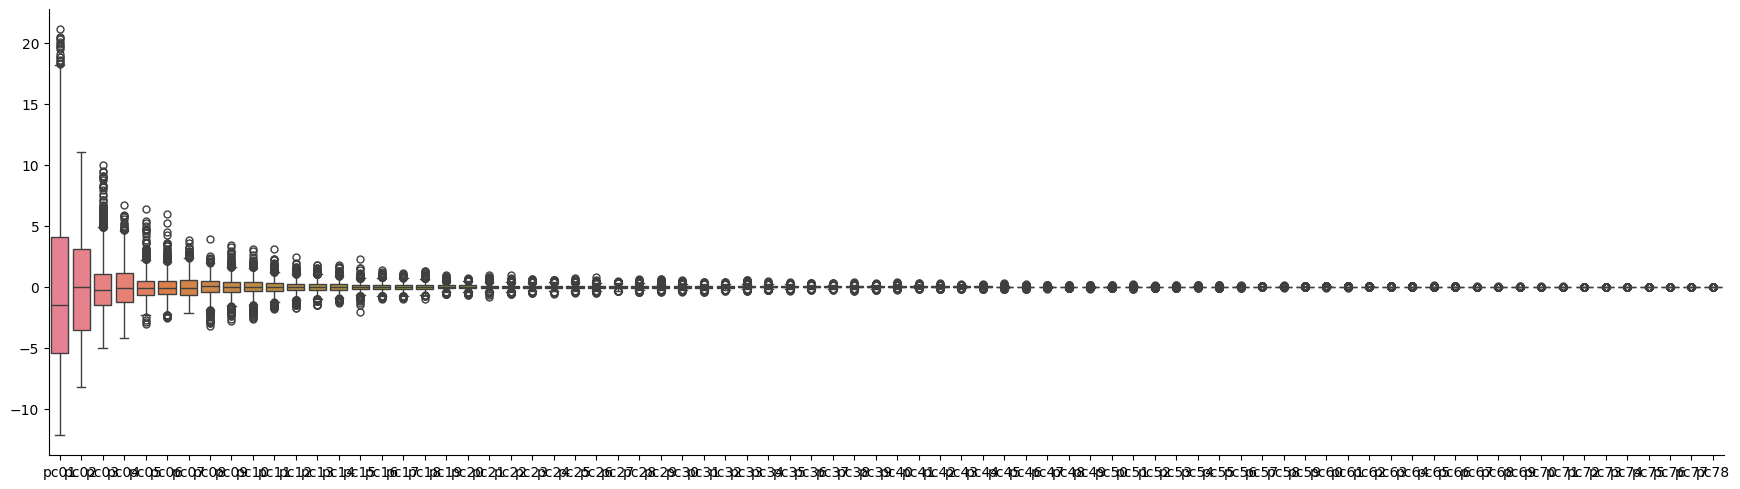

In [66]:
sns.catplot(data =df_pca_pc, kind ='box',aspect=3.5)
plt.show()

In [67]:
# Summary statistics
df_pca_pc.describe().round(3)

pc01      pc02      pc03      pc04      pc05      pc06      pc07  \
count  2000.000  2000.000  2000.000  2000.000  2000.000  2000.000  2000.000   
mean      0.000    -0.000    -0.000     0.000     0.000     0.000    -0.000   
std       6.949     4.097     2.105     1.702     1.010     0.915     0.894   
min     -12.152    -8.243    -5.025    -4.213    -3.053    -2.549    -2.153   
25%      -5.402    -3.556    -1.477    -1.255    -0.682    -0.586    -0.638   
50%      -1.488     0.008    -0.266    -0.099    -0.110    -0.064    -0.099   
75%       4.072     3.085     1.063     1.094     0.488     0.489     0.550   
max      21.111    11.024     9.974     6.732     6.412     5.988     3.844   

           pc08      pc09      pc10  ...      pc69      pc70      pc71  \
count  2000.000  2000.000  2000.000  ...  2000.000  2000.000  2000.000   
mean      0.000    -0.000    -0.000  ...     0.000     0.000     0.000   
std       0.790     0.691     0.642  ...     0.003     0.002     0.002   
min      -3.199    -2.836    -2.618  ...    -0.016    -0.011    -0.019   
25%      -0.465    -0.398    -0.360  ...    -0.001    -0.001    -0.001   
50%       0.025     0.012     0.006  ...    -0.000     0.000     0.000   
75%       0.505     0.407     0.411  ...     0.001     0.001     0.001   
max       3.910     3.417     3.090  ...     0.025     0.023     0.022   

           pc72      pc73      pc74      pc75      pc76    pc77    pc78  
count  2000.000  2000.000  2000.000  2000.000  2000.000  2000.0  2000.0  
mean     -0.000    -0.000    -0.000     0.000    -0.000    -0.0     0.0  
std       0.001     0.001     0.001     0.000     0.000     0.0     0.0  
min      -0.008    -0.009    -0.004    -0.004    -0.002    -0.0    -0.0  
25%      -0.000    -0.000    -0.000    -0.000    -0.000    -0.0    -0.0  
50%      -0.000     0.000     0.000     0.000     0.000    -0.0    -0.0  
75%       0.000     0.000     0.000     0.000     0.000     0.0     0.0  
max       0.009     0.010     0.004     0.005     0.003     0.0     0.0  

[8 rows x 78 columns]

In [68]:
# Visualize the standard deviation
df_pca_pc.describe().loc['std']

pc01    6.948734
pc02    4.096624
pc03    2.104534
pc04    1.702240
pc05    1.010189
          ...   
pc74    0.000600
pc75    0.000496
pc76    0.000303
pc77    0.000026
pc78    0.000005
Name: std, Length: 78, dtype: float64

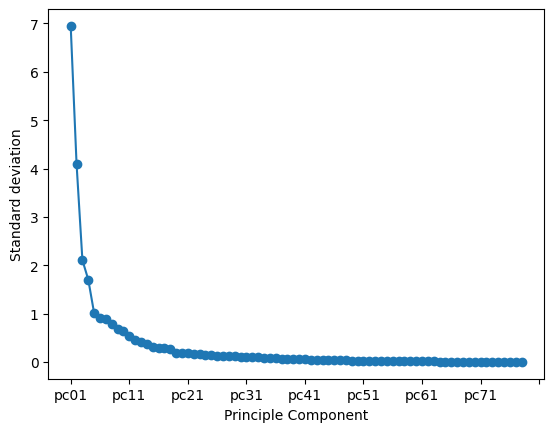

In [69]:
# show the standard deviation vs the PC number
fig, ax =plt.subplots()
df_pca_pc.describe().loc['std'].plot(ax=ax,marker='o' )
ax.set_xlabel('Principle Component')
ax.set_ylabel('Standard deviation')

plt.show()

In [70]:
pca=PCA(n_components=6)
pca_cor =pca.fit_transform(Xfeature_trans)
print("The variance explained by the two first principal components is: ", sum(pca.explained_variance_ratio_))

The variance explained by the two first principal components is:  0.9514670820698918


According to the PCA results and the graph, we can that the first 6 pcs can explain 95% of the variance. So we will use the first 6 pcs to further study the system.

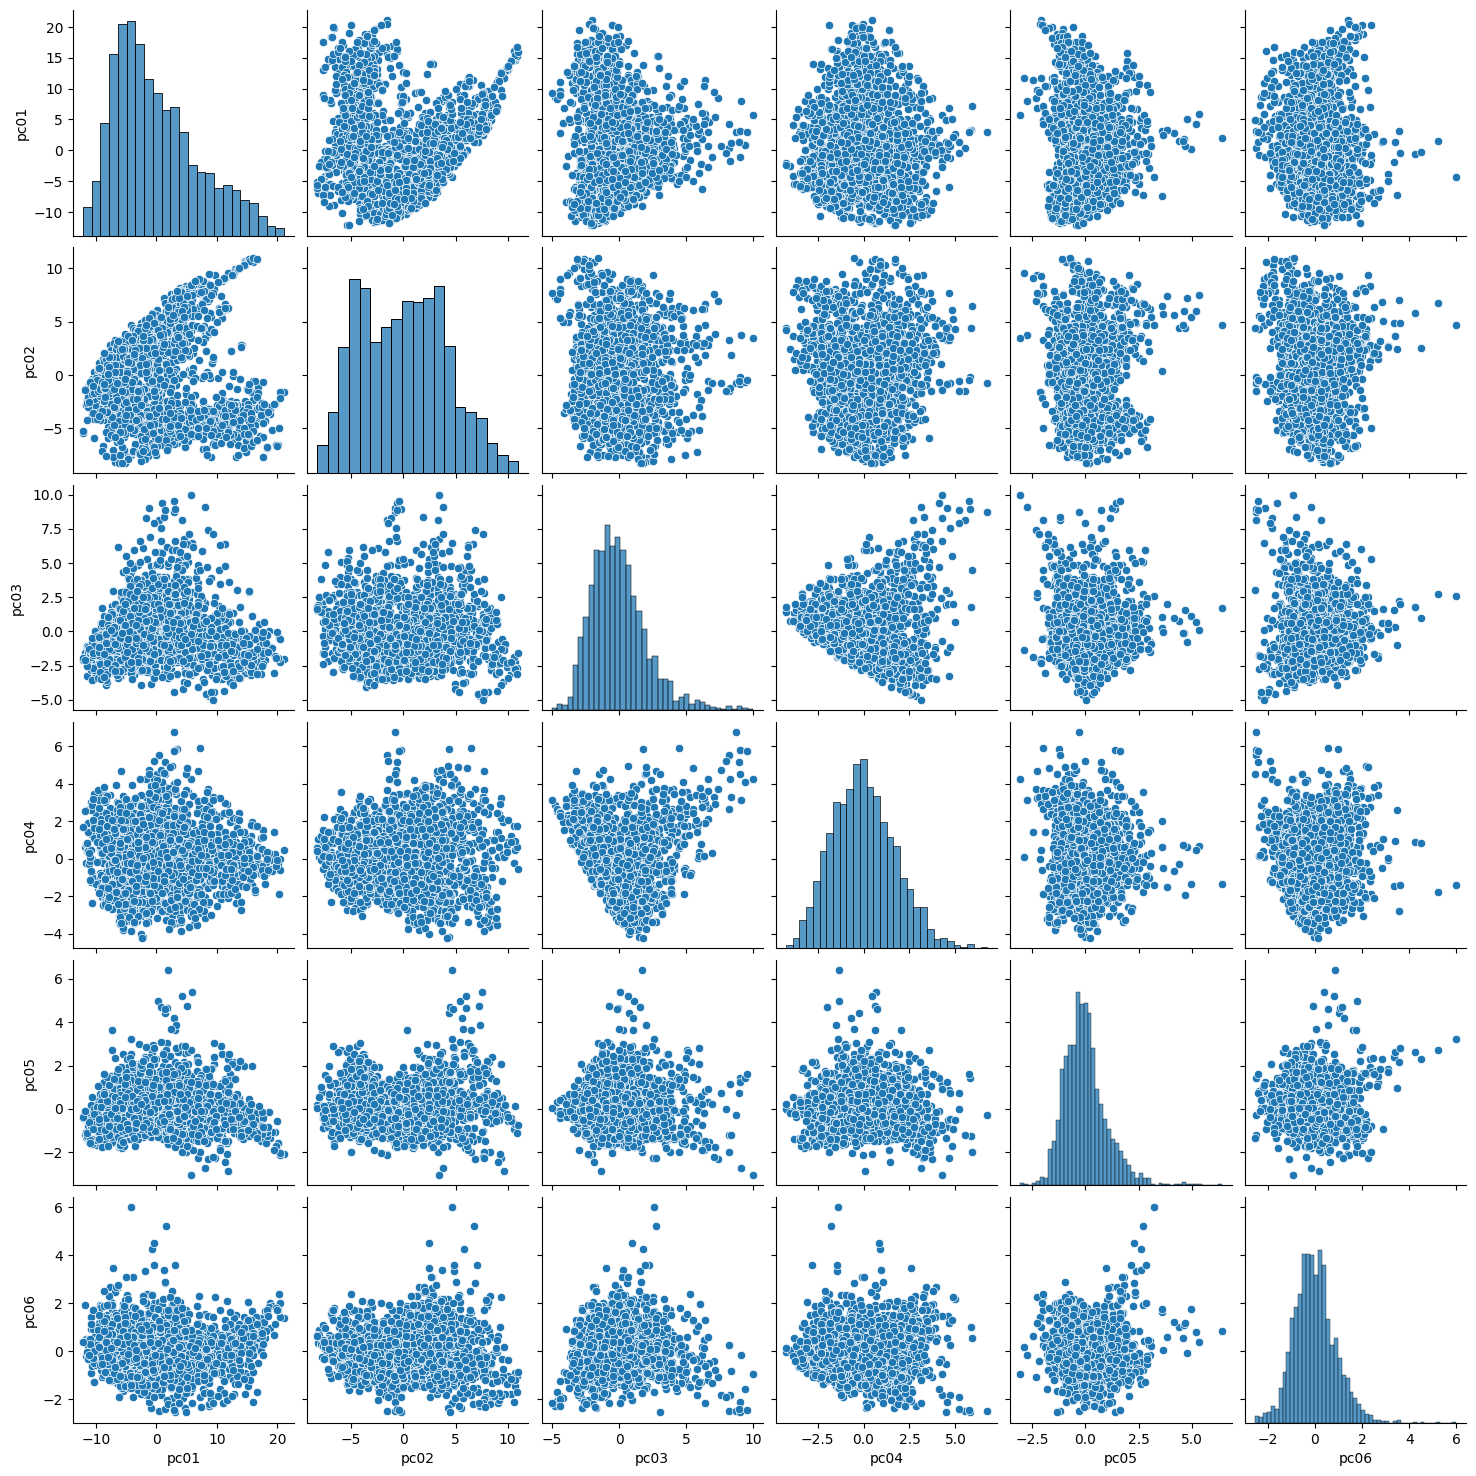

In [71]:
sns.pairplot(data = df_pca_pc.iloc[:, :6])

plt.show()

In [72]:
df_pca_pc['corrosion'] =df.corrosion

In [73]:
df_pca_pc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2000 entries, 0 to 1999
Data columns (total 79 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   pc01       2000 non-null   float64
 1   pc02       2000 non-null   float64
 2   pc03       2000 non-null   float64
 3   pc04       2000 non-null   float64
 4   pc05       2000 non-null   float64
 5   pc06       2000 non-null   float64
 6   pc07       2000 non-null   float64
 7   pc08       2000 non-null   float64
 8   pc09       2000 non-null   float64
 9   pc10       2000 non-null   float64
 10  pc11       2000 non-null   float64
 11  pc12       2000 non-null   float64
 12  pc13       2000 non-null   float64
 13  pc14       2000 non-null   float64
 14  pc15       2000 non-null   float64
 15  pc16       2000 non-null   float64
 16  pc17       2000 non-null   float64
 17  pc18       2000 non-null   float64
 18  pc19       2000 non-null   float64
 19  pc20       2000 non-null   float64
 20  pc21    

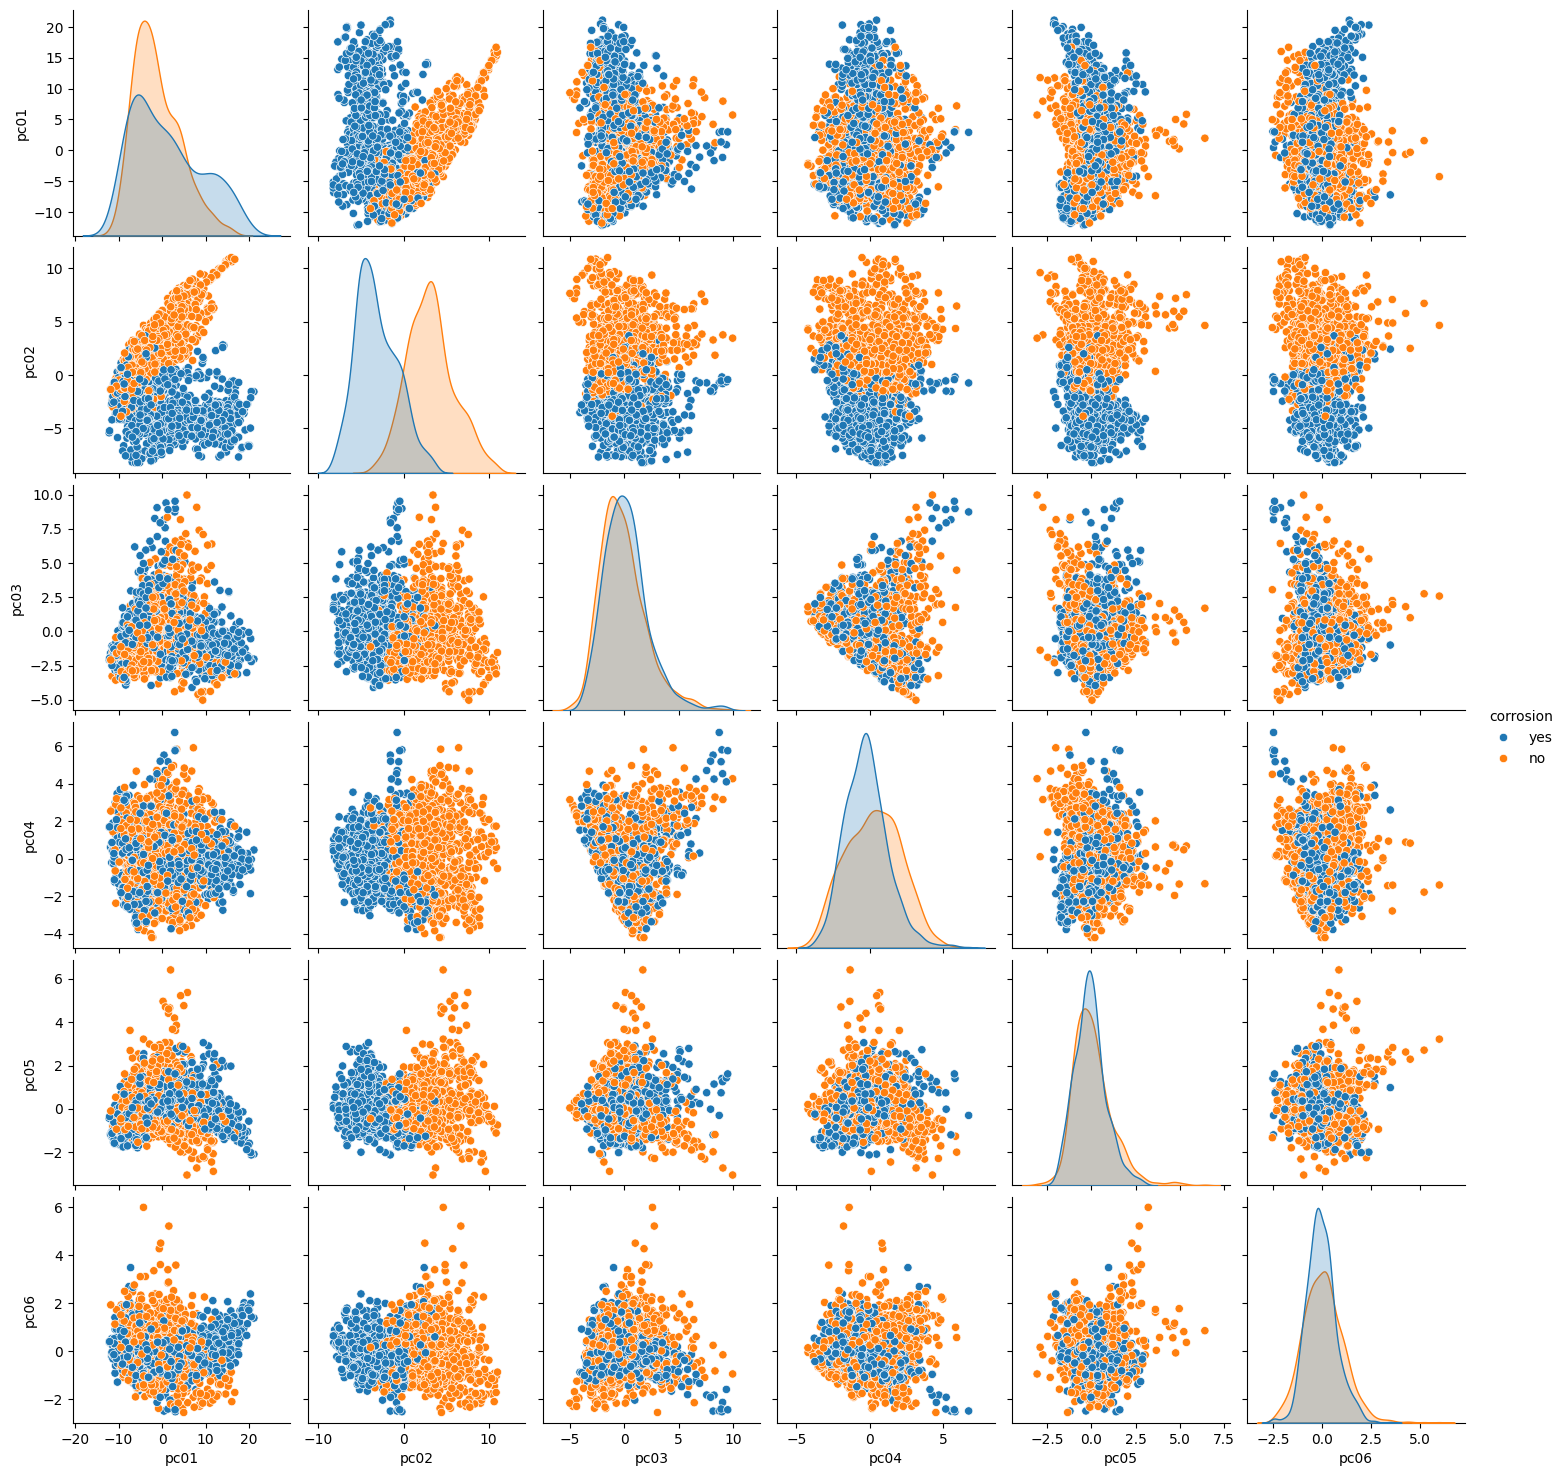

In [74]:
sns.pairplot(data = df_pca_pc,
             vars=['pc%02d' % d for d in range(1, 6+1)],
             hue='corrosion',
             diag_kws={'common_norm': False})

plt.show()

### using the original data to do the PCA

In [75]:

df_copy=df.copy()

In [76]:
df_copy_standardize =StandardScaler().fit_transform(df_copy.select_dtypes('number').copy())

In [77]:
# find the best number of clusters
tots_within=[]
K=range(1,21)
for k in K:
    km = KMeans(n_clusters=k, random_state=121, n_init=25, max_iter=500).fit(df_copy_standardize)
    tots_within.append(km.inertia_)

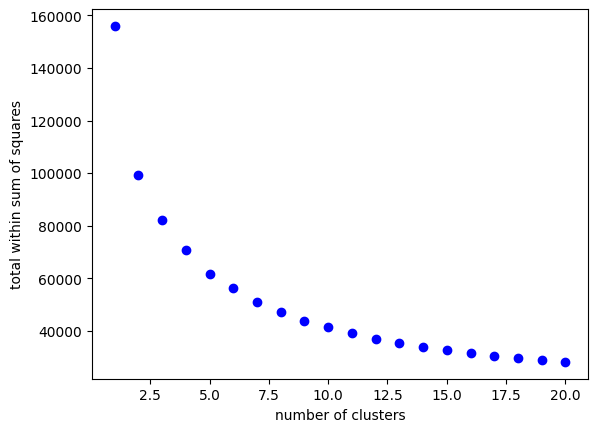

In [78]:
# Visualize the KNEE BEND plot as a line chart
fig, ax =plt.subplots()
ax.plot(K, tots_within, 'bo')
ax.set_xlabel('number of clusters')
ax.set_ylabel('total within sum of squares')

plt.show()

In [79]:
df_pca_original=PCA().fit_transform(df_copy_standardize)

In [80]:
df_pca_original

array([[ 1.35089690e+01, -1.94418734e+00,  1.11558424e+00, ...,
         1.32513716e-02, -4.51892000e-05, -5.42149351e-04],
       [ 1.55650980e+00,  2.90357736e+00, -7.19988645e-01, ...,
        -1.25924746e-03, -1.52175770e-04, -1.05176628e-04],
       [-2.40182121e+00,  5.75564586e+00,  4.62058244e-02, ...,
        -4.03051762e-04, -7.09449500e-05,  7.95181306e-05],
       ...,
       [-2.30263064e+00, -2.66345263e+00,  1.34177871e+00, ...,
        -1.39660702e-03, -8.95358466e-05, -3.09231350e-04],
       [ 6.27071866e-01, -2.16413285e+00, -3.54160715e+00, ...,
        -8.41639537e-04,  1.32713368e-04, -6.91215809e-05],
       [-4.48090500e+00, -6.56799670e-01, -1.68763113e-01, ...,
        -1.26431644e-04,  2.58805995e-04,  1.42730485e-04]])

In [81]:
df_pca_original=pd.DataFrame(df_pca_original,
                       columns=['pc%02d' % d for d in range(1,df_pca.shape[1]+1)])

In [82]:
df_pca_original['corrosion'] =df.corrosion

In [83]:
df_pca_original['y'] =np.where(df.corrosion=='yes',1,0)

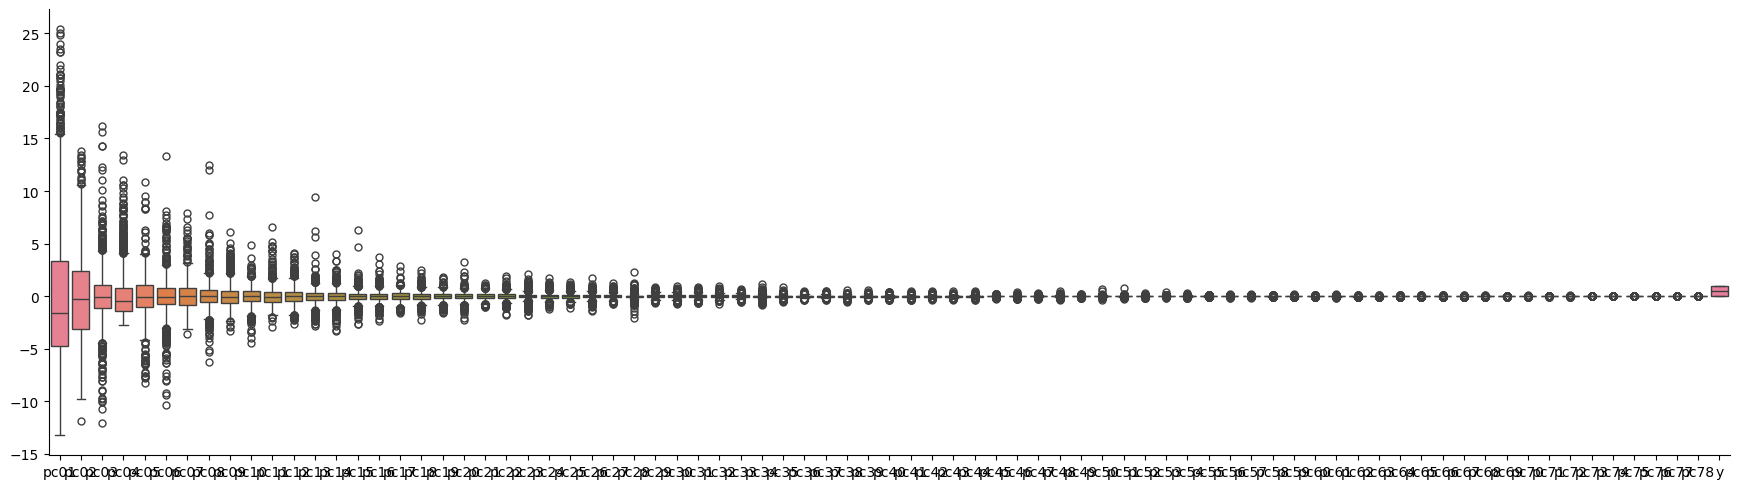

In [84]:
sns.catplot(data =df_pca_original, kind ='box',aspect=3.5)
plt.show()

In [89]:
pca=PCA(n_components=6)
pca_cor =pca.fit_transform(df_copy_standardize)
print("The variance explained by the two first principal components is: ", sum(pca.explained_variance_ratio_))

The variance explained by the two first principal components is:  0.8991427806492313


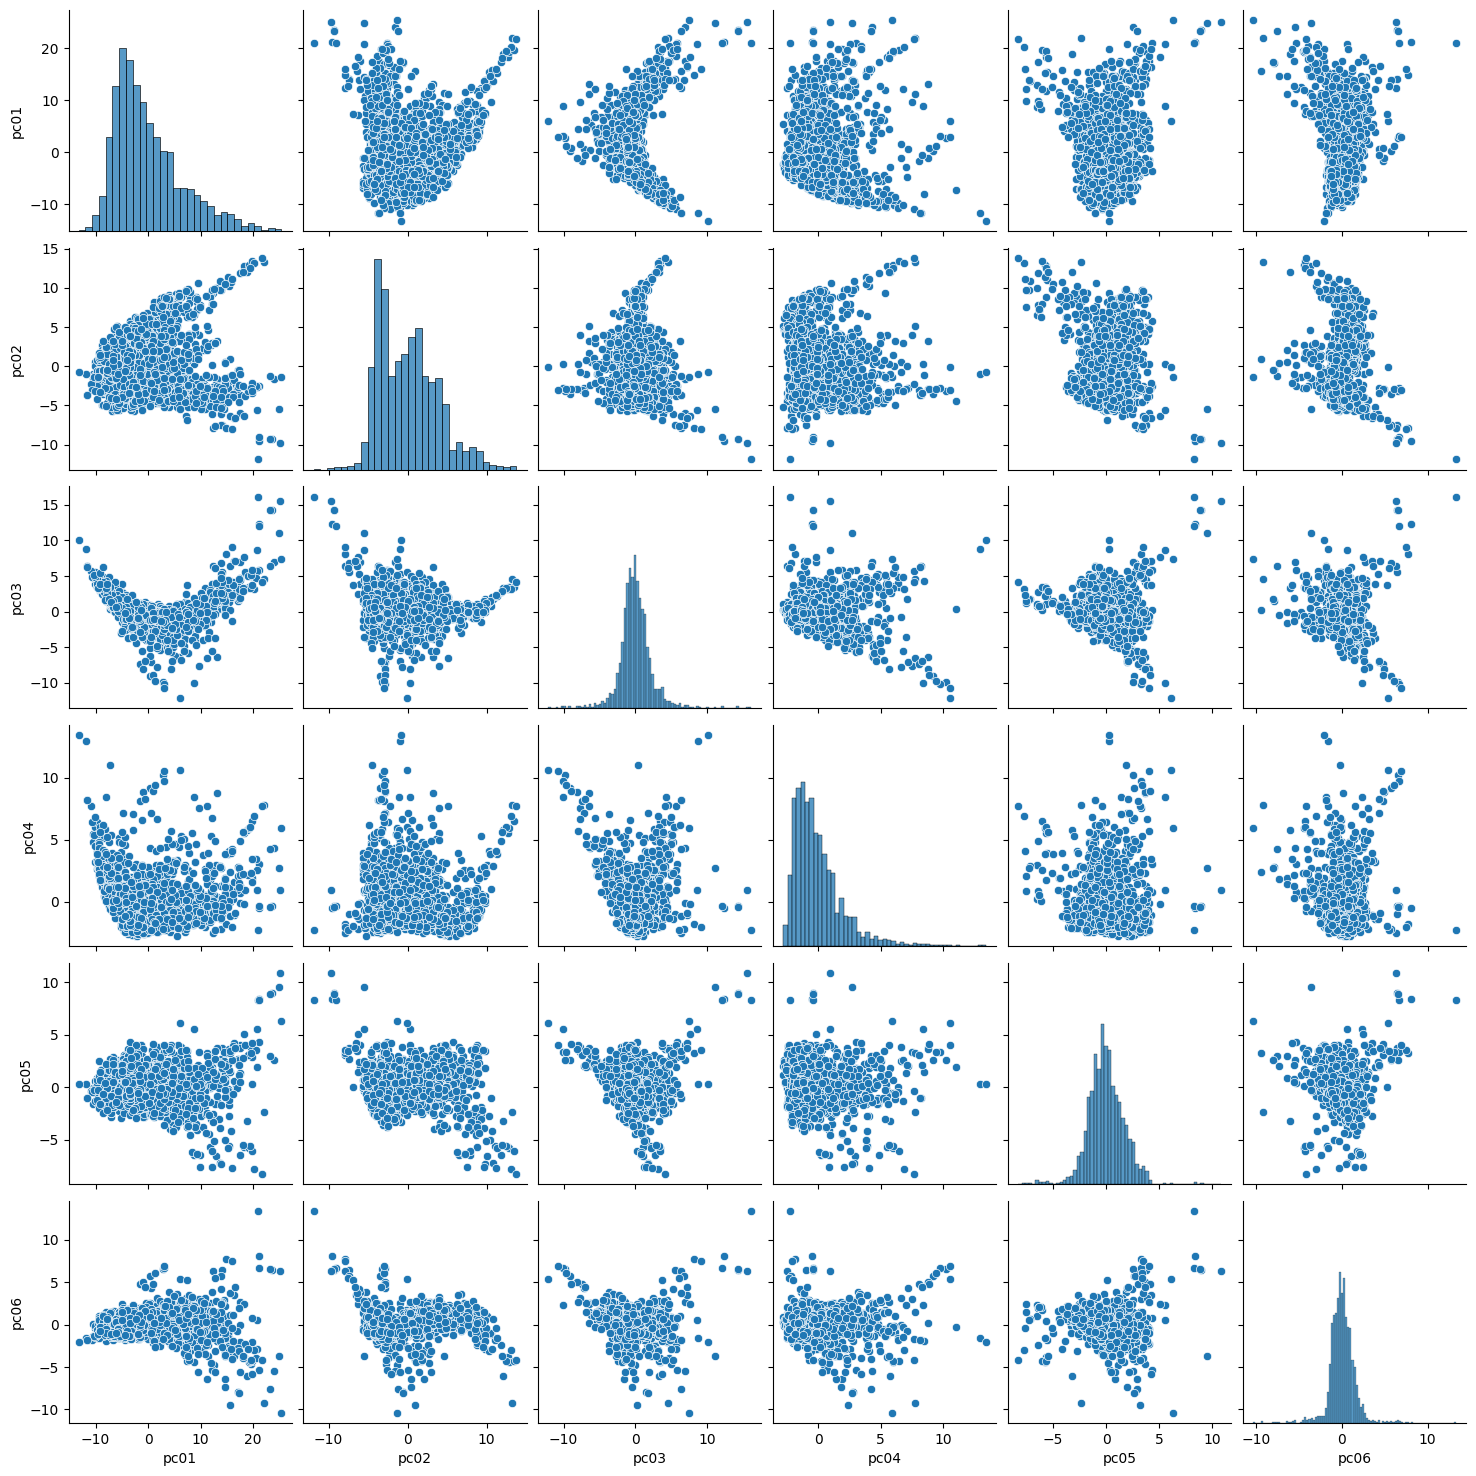

In [90]:
sns.pairplot(data = df_pca_original.iloc[:, :6])

plt.show()

In [91]:
df_pca_original['corrosion'] =df.corrosion

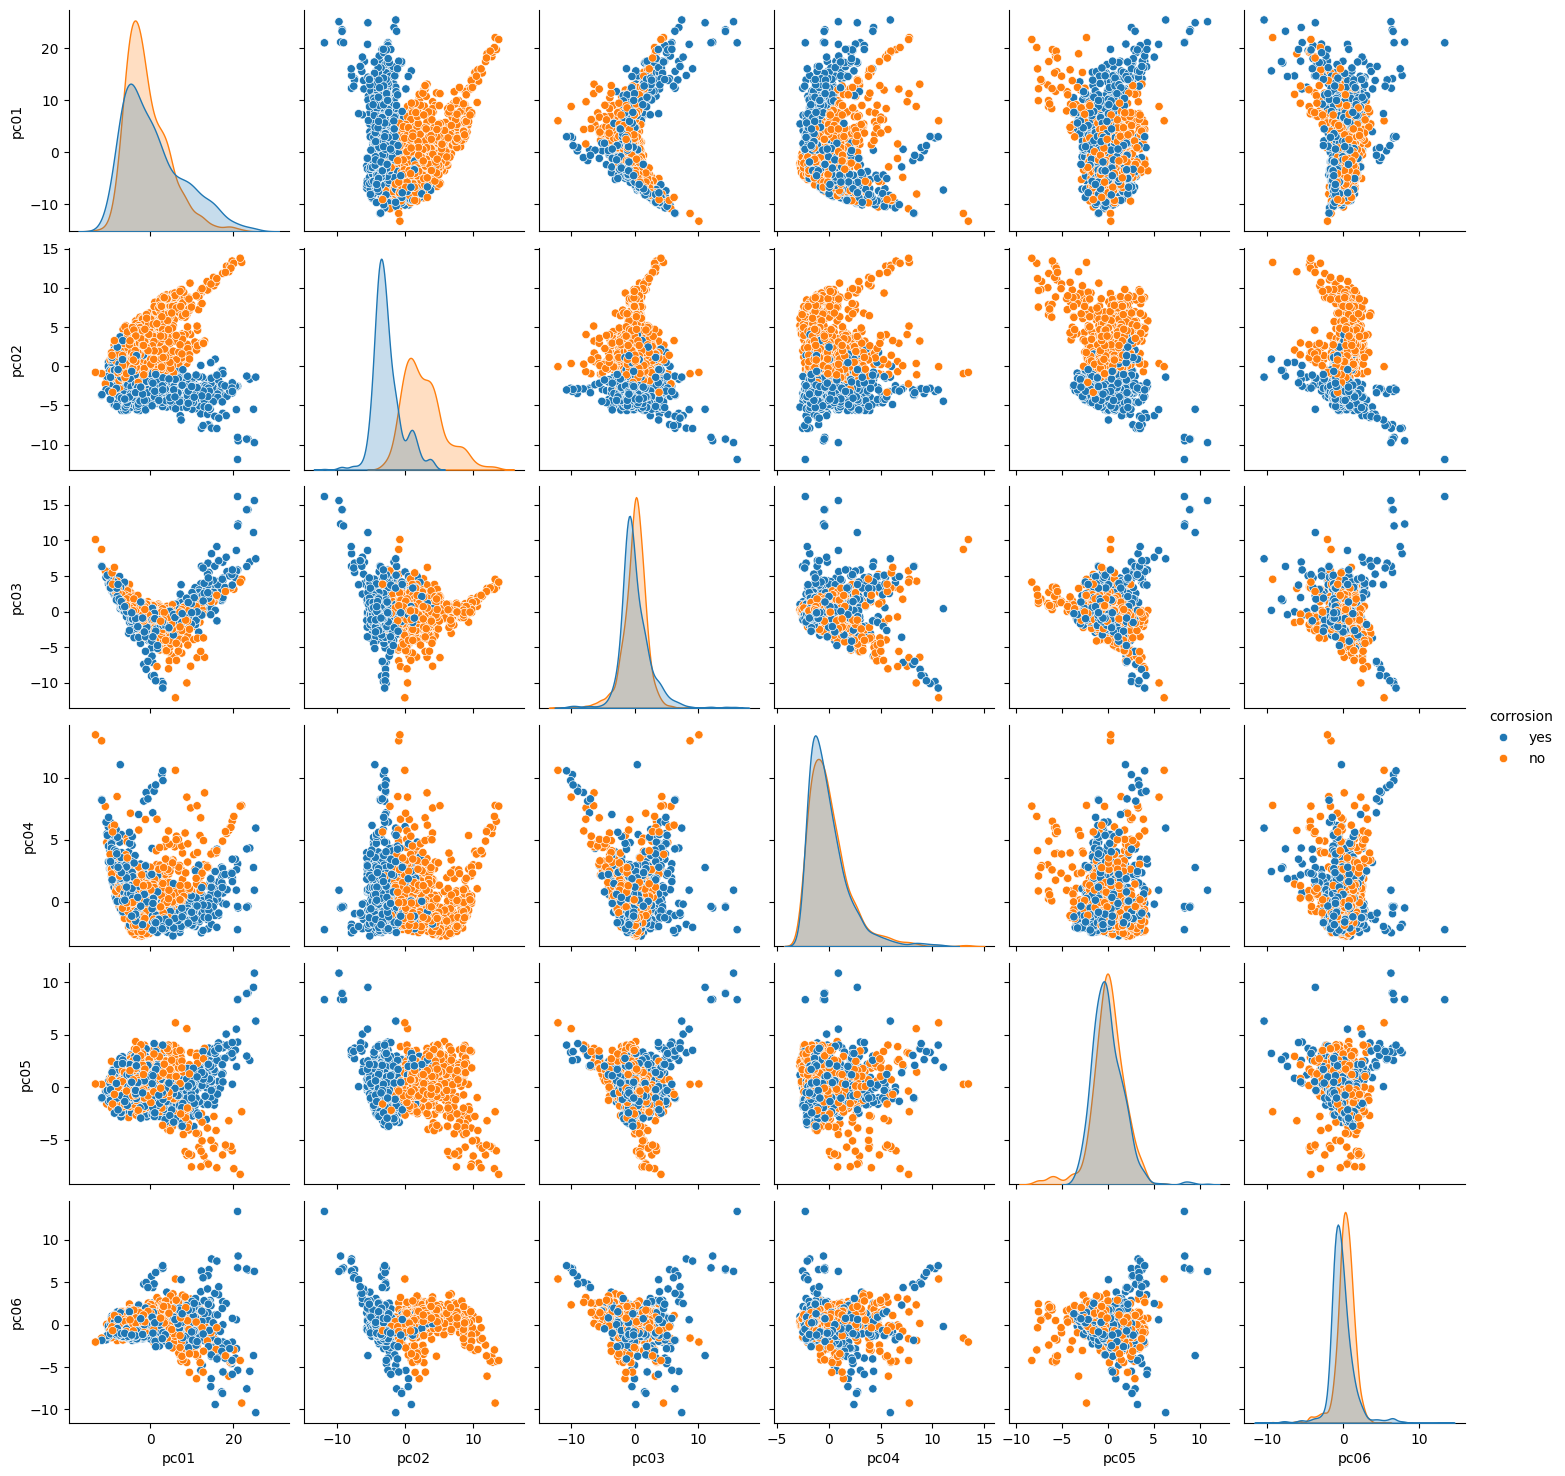

In [92]:
sns.pairplot(data = df_pca_original,
             vars=['pc%02d' % d for d in range(1, 6+1)],
             hue='corrosion',
             diag_kws={'common_norm': False})

plt.show()